# Proof-of-Concept: Simplified Face Analysis - Model Development

This notebook demonstrates a basic prototype implementation of age and
gender estimation models for the NutriGenius proof-of-concept.

## Table of Contents

1.  [Introduction](#introduction)
2.  [Setup](#setup)
3.  [Loading Processed Data](#loading)
4.  [Age Model Development](#age-model)
5.  [Gender Model Development](#gender-model)
6.  [Model Evaluation](#evaluation)
7.  [Model Conversion for Mobile](#conversion)
8.  [Conclusion](#conclusion)

## 1. Introduction

In this proof-of-concept notebook, we'll implement simplified models
for age and gender prediction from facial images. These models are
intentionally designed to be lightweight and quick to implement,
suitable for a prototype demonstration rather than production use.

Key simplifications in this prototype include:

-   Using transfer learning with pre-trained models instead of custom
    architectures
-   Limited hyperparameter tuning
-   Basic data augmentation
-   Simplified evaluation metrics

The goal is to demonstrate technical feasibility with reasonable
accuracy while keeping implementation complexity low.

> **Note**: This prototype implementation is intended for
> proof-of-concept purposes only and would require significant
> enhancement for production use.

## 2. Setup

First, let's import the necessary libraries and set up our environment.

In [1]:
# OPTIMIZED CONFIGURATION - Memory Management Without Forcing CPU
# This cell helps balance memory usage for your hardware configuration

import os
import warnings
import gc

# ==== HARDWARE-SPECIFIC CONFIGURATION ====
# Allow GPU usage but with memory growth to prevent OOM errors
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # More efficient GPU memory usage

print("🔍 HARDWARE CONFIGURATION: GPU + RAM OPTIMIZATION")
print("✅ GPU enabled with memory growth - preventing out-of-memory errors")
print("✅ Memory optimization enabled for more reliable training")

# ==== MEMORY OPTIMIZATION ====
# Improved garbage collection to free memory more aggressively
gc.enable()

# Clear any existing memory
gc.collect()

# ==== INSTRUCTIONS FOR THE USER ====
print("\n🔍 IMPORTANT INSTRUCTIONS:")
print("1. Run this cell FIRST (before any other code)")
print("2. If experiencing crashes, try reducing batch size in later cells")
print("3. For best results, close other applications while training")
print("\nℹ️ This configuration balances performance and stability")

🔍 HARDWARE CONFIGURATION: GPU + RAM OPTIMIZATION
✅ GPU enabled with memory growth - preventing out-of-memory errors
✅ Memory optimization enabled for more reliable training

🔍 IMPORTANT INSTRUCTIONS:
1. Run this cell FIRST (before any other code)
2. If experiencing crashes, try reducing batch size in later cells
3. For best results, close other applications while training

ℹ️ This configuration balances performance and stability


In [2]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
import yaml
import cv2
from glob import glob
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Verify CPU-only mode is active
print(f"TensorFlow devices available: {tf.config.list_physical_devices()}")
if not tf.config.list_physical_devices('GPU'):
    print("✅ Confirmed: Running in CPU-only mode")
else:
    print("⚠️ Warning: GPU still detected. Please restart kernel and run the first cell before this one.")

# Configure plots
plt.style.use('seaborn-whitegrid')
sns.set_context('notebook')

# Add project root to path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '../..')))

# Import utility functions - ENHANCED INTEGRATION WITH UTILITY MODULES
from src.utils.common import load_config, create_directory, plot_training_history, convert_to_tflite
from src.utils.data_processing import process_utk_face_dataset, normalize_image, create_tf_dataset_from_dataframe
from src.utils.visualization import plot_confusion_matrix, plot_distribution, plot_model_predictions

print("✅ Utilitas berhasil diimpor")

TensorFlow devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
⚠️ Warning: GPU still detected. Please restart kernel and run the first cell before this one.
✅ Utilitas berhasil diimpor


C:\Users\ASUS\AppData\Local\Temp\ipykernel_45348\1293107793.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
# CRITICAL FIX: Define all paths at the beginning of the notebook
# This ensures paths are defined even after kernel restarts

# Define project root directory
MODEL_ROOT = r"D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model"

# Directly define all paths inside Model directory
UTK_FACE_DIR = os.path.join(MODEL_ROOT, "data", "raw", "UTKFace")
PROCESSED_DATA_DIR = os.path.join(MODEL_ROOT, "data", "processed", "UTKFace")
METADATA_CSV = os.path.join(PROCESSED_DATA_DIR, "metadata.csv")
AGE_MODEL_PATH = os.path.join(MODEL_ROOT, "models", "age_model")
GENDER_MODEL_PATH = os.path.join(MODEL_ROOT, "models", "gender_model")
AGE_TFLITE_PATH = os.path.join(MODEL_ROOT, "models", "age_model.tflite")
GENDER_TFLITE_PATH = os.path.join(MODEL_ROOT, "models", "gender_model.tflite")

# Create directories
for path in [UTK_FACE_DIR, PROCESSED_DATA_DIR, os.path.dirname(AGE_MODEL_PATH), 
             os.path.dirname(GENDER_MODEL_PATH)]:
    os.makedirs(path, exist_ok=True)

# Still load config for model parameters (not paths)
CONFIG_PATH = os.path.join(MODEL_ROOT, "config", "model_config.yaml")
config = load_config(CONFIG_PATH)
face_config = config['face_detection']
age_config = face_config['age_model']
gender_config = face_config['gender_model']

print("✅ All paths defined and directories created")

2025-03-21 06:31:18,214 - src.utils.common - INFO - Configuration loaded from D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\config\model_config.yaml


✅ All paths defined and directories created


## 3. Loading Processed Data

Let's load and prepare the processed UTKFace dataset.

In [4]:
# ROBUST DATA LOADING WITH ERROR HANDLING
# Enhanced version of data loading code to prevent crashes

try:
    # First verify paths exist
    print(f"Checking path configurations:")
    print(f"MODEL_ROOT: {MODEL_ROOT}")
    print(f"METADATA_CSV path: {METADATA_CSV}")
    print(f"UTK_FACE_DIR path: {UTK_FACE_DIR}")
    
    # Verify directories exist
    if not os.path.exists(os.path.dirname(METADATA_CSV)):
        print(f"📁 Creating directory: {os.path.dirname(METADATA_CSV)}")
        os.makedirs(os.path.dirname(METADATA_CSV), exist_ok=True)
    
    if not os.path.exists(UTK_FACE_DIR):
        print(f"⚠️ UTK Face directory does not exist: {UTK_FACE_DIR}")
        print(f"📁 Creating directory: {UTK_FACE_DIR}")
        os.makedirs(UTK_FACE_DIR, exist_ok=True)
    
    # Check if processed metadata exists with validation
    metadata_exists = os.path.exists(METADATA_CSV)
    print(f"Does metadata CSV exist? {metadata_exists}")
    
    if metadata_exists:
        try:
            # Memory-efficient loading with chunking
            print(f"Loading preprocessed metadata from {METADATA_CSV}")
            # First check file size to determine approach
            file_size_mb = os.path.getsize(METADATA_CSV) / (1024 * 1024)
            print(f"Metadata file size: {file_size_mb:.2f} MB")
            
            if file_size_mb > 100:  # For large files
                print("Large metadata file detected, using chunked loading")
                # Use chunking for large files
                chunk_size = 10000  # Adjust based on file size
                chunks = []
                for chunk in pd.read_csv(METADATA_CSV, chunksize=chunk_size):
                    chunks.append(chunk)
                df = pd.concat(chunks)
                del chunks  # Free memory
                gc.collect()  # Force garbage collection
            else:
                # Standard loading for smaller files
                df = pd.read_csv(METADATA_CSV)
                
            # Validate dataframe has expected columns
            expected_cols = ['path', 'age', 'gender']
            missing_cols = [col for col in expected_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Metadata CSV missing expected columns: {missing_cols}")
                
            # Check for missing values in critical columns
            for col in expected_cols:
                null_count = df[col].isnull().sum()
                if null_count > 0:
                    print(f"⚠️ Warning: Column '{col}' has {null_count} missing values")
            
            # Verify all image paths exist
            print("Verifying sample of image paths...")
            sample_size = min(5, len(df))
            sample_paths = df['path'].sample(sample_size).tolist()
            for i, path in enumerate(sample_paths):
                exists = os.path.exists(path)
                print(f"  Sample path {i+1}: {'✅' if exists else '❌'} {path}")
                
        except Exception as e:
            print(f"❌ Error loading metadata CSV: {str(e)}")
            print("Falling back to dataset processing")
            metadata_exists = False
    
    if not metadata_exists:
        print(f"Generating metadata by processing UTKFace dataset from {UTK_FACE_DIR}")
        # Count images before processing
        image_files = glob(os.path.join(UTK_FACE_DIR, "*.jpg"))
        if not image_files:
            print(f"⚠️ Warning: No images found in {UTK_FACE_DIR}")
            print(f"Please ensure the UTKFace dataset is downloaded to this location.")
            raise FileNotFoundError(f"No images found in {UTK_FACE_DIR}")
        else:
            print(f"Found {len(image_files)} images in directory")
            
        # Process dataset with memory monitoring
        print("Processing images, this may take a while...")
        df = process_utk_face_dataset(UTK_FACE_DIR, METADATA_CSV)
    
    # Final validation
    print(f"Dataset loaded successfully with {len(df)} images")
    print(f"Memory usage of dataframe: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
    
    # Display distribution of ages and genders
    print("\nAge statistics:")
    print(f"Min age: {df['age'].min()}")
    print(f"Max age: {df['age'].max()}")
    print(f"Mean age: {df['age'].mean():.2f}")
    
    print("\nGender distribution:")
    print(df['gender'].value_counts())
    
    # Display first few rows
    display(df.head())
    
except Exception as e:
    print(f"❌ CRITICAL ERROR: {str(e)}")
    print("\n=== TROUBLESHOOTING STEPS ===")
    print("1. Check if the UTKFace dataset is downloaded to the correct location")
    print("2. Verify all paths are accessible and have correct permissions")
    print("3. Try running this cell only after restarting the kernel")
    print("4. Ensure you have at least 4GB of free RAM")
    raise

Checking path configurations:
MODEL_ROOT: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model
METADATA_CSV path: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\processed\UTKFace\metadata.csv
UTK_FACE_DIR path: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\raw\UTKFace
Does metadata CSV exist? True
Loading preprocessed metadata from D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\processed\UTKFace\metadata.csv
Metadata file size: 3.40 MB
Verifying sample of image paths...
  Sample path 1: ✅ D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\raw\UTKFace\40_1_3_20170119183059633.jpg
  Sample path 2: ✅ D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\raw\UTKFace\38_1_0_20170117154130828.jpg
  Sample path 3: ✅ D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-

age  gender   race  race_id  \
0  100    male  White        0   
1  100    male  White        0   
2  100  female  White        0   
3  100  female  White        0   
4  100  female  White        0   

                                                path  
0  D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...  
1  D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...  
2  D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...  
3  D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...  
4  D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...

In [5]:
# Function to preprocess images - ENHANCED WITH CONSISTENT PROCESSING
def preprocess_image(image_path, target_size=(200, 200)):
    """
    Preprocess an image for model input with improved consistency and error handling.
    
    Args:
        image_path: Path to the image
        target_size: Target size for resizing
        
    Returns:
        Preprocessed image as numpy array
    """
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image at {image_path}. Using empty placeholder.")
            # Return zeros if image can't be read
            return np.zeros((*target_size, 3), dtype=np.float32)
        
        # Convert to RGB (our model will expect RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # CRITICAL FIX: Ensure all images are resized to exactly the same dimensions
        # This prevents the "Cannot batch tensors with different shapes" error
        img = cv2.resize(img, target_size)
        
        # Normalize pixel values to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        # Return zeros if there's an error
        return np.zeros((*target_size, 3), dtype=np.float32)

# Add normalize_image function for consistency
def normalize_image(img):
    """
    Normalize image pixel values to [0, 1].
    
    Args:
        img: Input image (numpy array)
        
    Returns:
        Normalized image
    """
    # Ensure the image is float32
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    
    # Normalize if needed (if max value > 1.0)
    if img.max() > 1.0:
        img = img / 255.0
        
    return img

In [6]:
# ENHANCED WITH AGE GROUP BALANCING
def create_balanced_datasets(df, batch_size=32, target_size=(200, 200)):
    """
    Create balanced datasets with equal distribution of age groups.
    
    Args:
        df: DataFrame with face data
        batch_size: Batch size for training
        target_size: Target image size
        
    Returns:
        Dictionary with age and gender datasets and dataframes
    """
    # Define age groups for better balancing
    df['age_group'] = pd.cut(
        df['age'], 
        bins=[0, 12, 19, 29, 39, 49, 59, 120],
        labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Age', 'Older Adult', 'Senior']
    )
    
    # Display original distribution
    print("Original age group distribution:")
    group_counts = df['age_group'].value_counts()
    print(group_counts)
    
    # IMPROVED BALANCING STRATEGY: Use target count approach
    # Set a target sample count for each group - around 3500 is reasonable
    # This allows underrepresented groups to be oversampled and overrepresented groups to be downsampled
    target_count = 3500
    balanced_df = pd.DataFrame()
    
    for group in group_counts.index:
        group_df = df[df['age_group'] == group]
        count = len(group_df)
        
        if count < target_count:
            # Oversample smaller groups with replacement
            sampled = group_df.sample(target_count, replace=True, random_state=42)
            print(f"Oversampling {group}: {count} → {target_count}")
        else:
            # Downsample larger groups without replacement
            sampled = group_df.sample(target_count, replace=False, random_state=42)
            print(f"Downsampling {group}: {count} → {target_count}")
        
        balanced_df = pd.concat([balanced_df, sampled])
    
    print("\nBalanced age group distribution:")
    print(balanced_df['age_group'].value_counts())
    
    # Split into train, validation, and test sets
    # Use stratification by age_group to maintain balance across splits
    train_df, temp_df = train_test_split(
        balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['age_group']
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['age_group']
    )

    print(f"Training set: {len(train_df)} images")
    print(f"Validation set: {len(val_df)} images")
    print(f"Test set: {len(test_df)} images")
    
    # Create binary gender labels
    train_df['gender_binary'] = train_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
    val_df['gender_binary'] = val_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
    test_df['gender_binary'] = test_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
    
    # CRITICAL FIX: Check and fix any problematic images before dataset creation
    print("\nVerifying and fixing problematic images:")
    problem_images = []

    for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df), desc="Checking images"):
        try:
            # Try to read the image directly with OpenCV
            img = cv2.imread(row['path'])
            if img is None:
                print(f"Cannot read image: {row['path']}")
                problem_images.append(idx)
                continue
                
            # Check dimensions
            h, w, c = img.shape
            if h != target_size[0] or w != target_size[1]:
                # Resize and save the image to the same path to fix it permanently
                resized = cv2.resize(img, target_size)
                cv2.imwrite(row['path'], resized)
                print(f"Resized image {row['path']} from {h}x{w} to {target_size[0]}x{target_size[1]}")
        except Exception as e:
            print(f"Error with image {row['path']}: {e}")
            problem_images.append(idx)

    print(f"Found {len(problem_images)} problem images")
    if problem_images:
        print("Removing problem images from dataframes")
        # Fix dataframes by removing problem images
        balanced_df = balanced_df.drop(problem_images).reset_index(drop=True)
        
        # Re-split dataset after fixing
        train_df, temp_df = train_test_split(
            balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['age_group']
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=42, stratify=temp_df['age_group']
        )
        
        # Re-create binary gender labels
        train_df['gender_binary'] = train_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
        val_df['gender_binary'] = val_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
        test_df['gender_binary'] = test_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
        
        print(f"Updated training set: {len(train_df)} images")
        print(f"Updated validation set: {len(val_df)} images")
        print(f"Updated test set: {len(test_df)} images")
    
    return {
        'dfs': (train_df, val_df, test_df),
        'balanced_df': balanced_df
    }

# Use the balanced dataset creation function
datasets = create_balanced_datasets(df, batch_size=gender_config['training']['batch_size'])
train_df, val_df, test_df = datasets['dfs']

Original age group distribution:
age_group
Young Adult    7366
Adult          4544
Child          3689
Senior         2747
Older Adult    2308
Middle Age     2248
Teen           1200
Name: count, dtype: int64
Downsampling Young Adult: 7366 → 3500
Downsampling Adult: 4544 → 3500
Downsampling Child: 3689 → 3500
Oversampling Senior: 2747 → 3500
Oversampling Older Adult: 2308 → 3500
Oversampling Middle Age: 2248 → 3500
Oversampling Teen: 1200 → 3500

Balanced age group distribution:
age_group
Child          3500
Teen           3500
Young Adult    3500
Adult          3500
Middle Age     3500
Older Adult    3500
Senior         3500
Name: count, dtype: int64
Training set: 17150 images
Validation set: 3675 images
Test set: 3675 images

Verifying and fixing problematic images:


Checking images:   0%|          | 0/24500 [00:00<?, ?it/s]

Found 0 problem images


## 4. Age Model Development

First, let's build and train the age prediction model.

In [7]:
# ROBUST DATASET CREATION WITH EAGER EXECUTION
# Create TensorFlow datasets for age prediction with reliable tensor shape handling
def create_dataset_with_explicit_resize(df, img_path_col, label_col, target_size=(200, 200), batch_size=32, shuffle=True):
    """
    Create a dataset with explicit eager execution preprocessing for reliable resizing.
    This prevents the 'Cannot batch tensors with different shapes' error by ensuring
    all images have exactly the same dimensions.
    
    Args:
        df: DataFrame containing image paths and labels
        img_path_col: Column name for image paths
        label_col: Column name for labels
        target_size: Target image size as tuple (height, width)
        batch_size: Batch size for training
        shuffle: Whether to shuffle the dataset
        
    Returns:
        TensorFlow dataset
    """
    # Convert labels to appropriate format
    labels = df[label_col].values
    
    # Create a function to load and process images using OpenCV (more reliable than TF ops)
    def process_path(path):
        # Read image with OpenCV for guaranteed shape control
        img = cv2.imread(path.numpy().decode('utf-8'))
        if img is None:
            # Return zeros if image can't be read
            return np.zeros((target_size[0], target_size[1], 3), dtype=np.float32)
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to exact target size
        img = cv2.resize(img, target_size)
        
        # Normalize
        img = img.astype(np.float32) / 255.0
        
        return img
    
    # Wrap the OpenCV function to work with TensorFlow
    def load_and_preprocess_image(path):
        img = tf.py_function(
            process_path,
            [path],
            tf.float32
        )
        # Set shape explicitly since py_function doesn't preserve it
        img.set_shape([target_size[0], target_size[1], 3])
        return img
    
    # Create the dataset from paths
    paths_ds = tf.data.Dataset.from_tensor_slices(df[img_path_col].values)
    image_ds = paths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Create label dataset
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Combine images and labels
    dataset = tf.data.Dataset.zip((image_ds, label_ds))
    
    # Shuffle if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(df), 10000), seed=42)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Apply additional preprocessing for age/gender if needed (can be empty)
def preprocess_for_age(image):
    # No additional preprocessing needed - already handled in dataset creation
    return image

def preprocess_for_gender(image):
    # No additional preprocessing needed - already handled in dataset creation
    return image

# RESTORED FROM ORIGINAL: Use original config batch size and input dimensions
batch_size = age_config['training']['batch_size']  # Original batch size from config
target_size = tuple(age_config['input_shape'][:2])  # Original dimensions (height, width)

print(f"Using original training specifications:")
print(f"- Batch size: {batch_size}")
print(f"- Image dimensions: {target_size}")

# Create datasets with the robust implementation
print("\nCreating age datasets with robust shape handling:")
train_age_dataset = create_dataset_with_explicit_resize(
    train_df, 
    'path', 
    'age',
    target_size=target_size,
    batch_size=batch_size
)

val_age_dataset = create_dataset_with_explicit_resize(
    val_df, 
    'path', 
    'age',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

test_age_dataset = create_dataset_with_explicit_resize(
    test_df, 
    'path', 
    'age',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

# Verify dataset shapes (optional)
def verify_dataset_shapes(dataset, expected_shape=(200, 200, 3), num_batches=3):
    """Verify shapes of images in the first few batches of a dataset."""
    print("Checking dataset image shapes...")
    
    all_consistent = True
    for i, (images, _) in enumerate(dataset.take(num_batches)):
        batch_shape = images.shape[1:]  # Skip batch dimension
        print(f"Batch {i}: shape = {batch_shape}")
        
        if batch_shape != expected_shape:
            print(f"❌ WARNING: Inconsistent shape found in batch {i}: {batch_shape}")
            all_consistent = False
        
        if i >= num_batches-1:
            break
    
    if all_consistent:
        print("✅ All checked batches have consistent shape")
    
    return all_consistent

# Verify the dataset shapes to confirm our fix
verify_dataset_shapes(train_age_dataset, expected_shape=target_size + (3,))

Using original training specifications:
- Batch size: 32
- Image dimensions: (200, 200)

Creating age datasets with robust shape handling:
Checking dataset image shapes...
Batch 0: shape = (200, 200, 3)
Batch 1: shape = (200, 200, 3)
Batch 2: shape = (200, 200, 3)
✅ All checked batches have consistent shape


True

In [8]:
# ENHANCED DATA AUGMENTATION - More extensive to improve model robustness
# RESTORED FROM ORIGINAL: Use original data augmentation with current features
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    # Add slight random cropping and resizing for increased robustness
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

def create_age_preprocessing_model(input_shape=(200, 200, 3)):
    """Create a preprocessing model with data augmentation for age prediction"""
    inputs = tf.keras.Input(shape=input_shape)
    # Apply augmentation only during training
    augmented = data_augmentation(inputs)
    # Ensure output is properly normalized
    outputs = augmented
    return tf.keras.Model(inputs, outputs, name="age_preprocessing")

# Create and display the preprocessing model
age_preprocessing_model = create_age_preprocessing_model(input_shape=target_size + (3,))
print("Data augmentation pipeline for age model:")
age_preprocessing_model.summary()

2025-03-21 06:33:52,621 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:52,647 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:52,677 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:52,701 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:53,005 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:33:53,103 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:53,136 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,178 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,210 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:53,421 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:33:53,483 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:53,511 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,537 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,559 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:53,703 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:53,726 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,752 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:53,775 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:33:53,824 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:33:53,871 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:53,945 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:33:54,163 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:54,186 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,212 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,238 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:54,291 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:54,310 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,340 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,362 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:54,731 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:54,752 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,775 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:54,794 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:55,040 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:33:55,123 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:55,147 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,172 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,194 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:55,354 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:33:55,403 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:55,424 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,451 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,471 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:55,612 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:55,634 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,657 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,675 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:33:55,710 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:33:55,734 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:55,794 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:33:55,884 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:55,920 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,955 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:55,981 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:33:56,034 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:33:56,055 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:56,082 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:33:56,110 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


Data augmentation pipeline for age model:
Model: "age_preprocessing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
# ENHANCED MODEL - Using transfer learning with proper preprocessing
# Build the age prediction model with better architecture
def create_age_model(input_shape=(200, 200, 3)):
    """
    Create an enhanced age prediction model using transfer learning
    with MobileNetV2 as the base model.
    """
    # Data Augmentation Layer (defined earlier)
    preprocessing_model = create_age_preprocessing_model(input_shape)
    
    # Base model (MobileNetV2)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Model architecture
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocessing_model(inputs)
    # Use MobileNetV2's preprocessing
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    # Pass through base model
    x = base_model(x, training=False)
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    # Add batch normalization for more stable training
    x = layers.BatchNormalization()(x)
    # First dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    # Second dense layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # Output layer (regression)
    outputs = layers.Dense(1)(x)
    
    # Create model
    model = tf.keras.Model(inputs, outputs, name="age_model")
    
    # Compile model with proper loss and metrics
    model.compile(
        optimizer=optimizers.Adam(learning_rate=age_config['training']['learning_rate']),
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Mean Absolute Error is more interpretable
    )

    return model

# Create the enhanced age model
age_model = create_age_model(input_shape=tuple(age_config['input_shape']))
age_model.summary()

2025-03-21 06:34:04,919 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:04,942 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:04,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,012 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:05,246 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:34:05,363 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:05,397 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,442 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,470 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:05,636 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:34:05,693 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:05,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,744 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,765 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:05,901 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:05,922 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,947 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:05,964 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:34:06,001 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:34:06,027 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:06,087 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:34:06,184 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:06,206 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:06,234 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:06,260 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:06,308 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:34:06,331 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:06,357 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:34:06,382 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:34:06,606 - tensorflow - WARNING - `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Model: "age_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 age_preprocessing (Function  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                  

In [10]:
# PERUBAHAN 4: CALLBACKS YANG LEBIH KOMPREHENSIF
# Define callbacks for training with TensorBoard dan monitoring yang lebih baik
age_callbacks = [
    callbacks.EarlyStopping(
        patience=age_config['training']['early_stopping_patience'],
        restore_best_weights=True,
        monitor='val_mae'
    ),
    callbacks.ModelCheckpoint(
        filepath=f"{AGE_MODEL_PATH}/checkpoint",
        save_best_only=True,
        monitor='val_mae'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    # Tambahkan TensorBoard untuk visualisasi training
    callbacks.TensorBoard(
        log_dir=f"{AGE_MODEL_PATH}/logs",
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    ),
    # Tambahkan CSV Logger untuk menyimpan metrik training
    callbacks.CSVLogger(
        f"{AGE_MODEL_PATH}/training_log.csv",
        separator=',',
        append=False
    )
]

print("✅ Callbacks untuk model age telah ditingkatkan")

✅ Callbacks untuk model age telah ditingkatkan


In [11]:
# BEST PRACTICE: MEMORY OPTIMIZATION FOR GPU TRAINING
# Specialized configuration for balanced GPU usage

print("⚙️ Configuring for optimal GPU memory usage")

# 1. GPU Memory Management - growth settings
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Found {len(physical_devices)} GPU(s): {physical_devices}")
    
    # STRATEGY: Use memory growth - allocate only what's needed
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("✅ Memory growth enabled for GPU")
    except Exception as e:
        print(f"ℹ️ Could not set memory growth: {e}")

else:
    print("ℹ️ No GPU devices found, running on CPU")

# 2. Clean any existing TensorFlow state
tf.keras.backend.clear_session()

# 3. Set environment variables to help with memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'  # More efficient GPU memory allocator
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'      # Reduce thread contention

# 4. Adjust batch size if needed based on available memory
original_batch_size = batch_size
if tf.config.list_physical_devices('GPU') and original_batch_size > 16:
    # For GPUs with limited VRAM, reduce batch size if it's set too high
    batch_size = min(16, original_batch_size)
    print(f"ℹ️ Adjusting batch size for GPU memory efficiency: {original_batch_size} → {batch_size}")
else:
    print(f"ℹ️ Using original batch size: {batch_size}")

# 5. Optional: Use mixed precision to reduce memory usage
try:
    # Try using mixed precision training
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("✅ Using mixed precision (float16) to reduce memory usage")
except Exception as e:
    print(f"ℹ️ Could not set mixed precision: {e}")

print("\n✅ Memory optimizations applied")
print("ℹ️ If you still experience crashes:")
print("   1. Reduce the batch size further")
print("   2. Run each cell one at a time (don't run all cells at once)")
print("   3. Close other applications to free up system resources")

⚙️ Configuring for optimal GPU memory usage
Found 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ℹ️ Could not set memory growth: Physical devices cannot be modified after being initialized
ℹ️ Adjusting batch size for GPU memory efficiency: 32 → 16
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


2025-03-21 06:34:15,115 - tensorflow - INFO - Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


✅ Using mixed precision (float16) to reduce memory usage

✅ Memory optimizations applied
ℹ️ If you still experience crashes:
   1. Reduce the batch size further
   2. Run each cell one at a time (don't run all cells at once)
   3. Close other applications to free up system resources


In [12]:
# Train the model with memory optimizations
epochs = age_config['training']['epochs']

print(f"Training model for {epochs} epochs...")

try:
    age_history = age_model.fit(
        train_age_dataset,
        validation_data=val_age_dataset,
        epochs=epochs,
        callbacks=age_callbacks,
        verbose=1,
        # Additional parameters to prevent memory issues
        workers=1,
        use_multiprocessing=False,
        max_queue_size=4
    )
    
    print("\n✅ Training complete!")

except tf.errors.ResourceExhaustedError as e:
    print(f"\n❌ GPU memory exhausted: {e}")
    print("\nTrying with reduced batch size...")
    
    # Recreate the model to ensure it's using clean state
    tf.keras.backend.clear_session()
    age_model = create_age_model(input_shape=tuple(age_config['input_shape']))
    
    # Create reduced batch size datasets
    reduced_batch_size = max(2, batch_size // 4)
    
    # Create reduced dataset with smaller batch size
    reduced_train_dataset = create_dataset_with_explicit_resize(
        train_df, 
        'path', 
        'age',
        target_size=target_size,
        batch_size=reduced_batch_size
    )
    
    reduced_val_dataset = create_dataset_with_explicit_resize(
        val_df, 
        'path', 
        'age',
        target_size=target_size,
        batch_size=reduced_batch_size,
        shuffle=False
    )
    
    # Train with reduced configuration
    print(f"Training with reduced batch size: {reduced_batch_size}")
    age_history = age_model.fit(
        reduced_train_dataset,
        validation_data=reduced_val_dataset,
        epochs=epochs,
        callbacks=[age_callbacks[0]],  # Just use early stopping to reduce overhead
        verbose=1
    )
    
    print("\n✅ Training completed with reduced batch size")

Training model for 50 epochs...
Epoch 1/50


2025-03-21 06:35:02,507 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:02,561 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:02,609 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:02,653 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:03,054 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:35:03,209 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:03,268 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:03,343 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:03,382 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:03,596 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:35:03,700 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:03,740 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:03,782 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:03,824 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:04,013 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:04,050 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,088 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,133 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:35:04,204 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:35:04,242 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:04,325 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:35:04,476 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:04,517 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,549 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,577 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:04,636 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:04,676 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,719 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:04,745 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:06,533 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:06,562 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:06,592 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:06,617 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:06,886 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:35:06,973 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:07,000 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,028 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,054 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:07,211 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:35:07,281 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:07,307 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,334 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,362 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:07,519 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:07,546 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,578 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,605 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:35:07,653 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:35:07,685 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:07,754 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:35:07,884 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:07,910 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,941 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:07,968 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:35:08,020 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:35:08,046 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:08,076 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:35:08,099 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


536/536 [==============================] - ETA: 0s - loss: 611.5098 - mae: 19.9026WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:20,440 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:20,464 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:20,498 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:20,521 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:20,568 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:20,591 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:20,621 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:20,642 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:20,945 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:20,974 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,002 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,024 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:40:21,066 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:40:21,092 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:21,157 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:40:21,267 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:21,292 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,321 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,345 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:21,545 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:21,577 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,605 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,628 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:21,759 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:21,891 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:21,918 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,961 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:21,993 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:22,196 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:30,382 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:30,423 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:30,464 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:30,491 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:30,700 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:30,777 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:30,800 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:30,828 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:30,852 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:30,986 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:31,035 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:31,057 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,083 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,107 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:31,242 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:31,270 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,300 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,320 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:40:31,361 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:40:31,386 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:31,464 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:40:31,556 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:31,584 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,611 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,636 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:31,683 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:31,705 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:31,756 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:32,650 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:32,677 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:32,705 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:32,729 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:32,924 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:32,995 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:33,018 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,045 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,067 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:33,215 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:33,281 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:33,312 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,348 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,378 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:33,528 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:33,571 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,611 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,635 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:40:33,677 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:40:33,703 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:33,764 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:40:33,844 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:33,867 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,894 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:33,914 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:33,960 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:33,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:34,007 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:34,030 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:36,037 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:36,062 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,089 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,110 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:36,317 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:36,390 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:36,414 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,440 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,463 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:36,600 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:36,664 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:36,700 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,735 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,760 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:36,911 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:36,937 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,965 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:36,987 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:40:37,025 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:40:37,050 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:37,136 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:40:37,243 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:37,268 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:37,299 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:37,322 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:37,368 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:37,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:37,421 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:37,445 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:40,025 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:40,050 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,077 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,097 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:40,298 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:40,434 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:40,456 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,481 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,502 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:40,639 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:40:40,740 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:40,764 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,790 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:40,813 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:41,019 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:41,042 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,068 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,088 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:40:41,123 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:40:41,153 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:41,210 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:40:41,351 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:41,374 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,401 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,424 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:40:41,469 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:40:41,492 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,519 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:40:41,539 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 06:40:41,915 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 06:40:46,699 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 348s 606ms/step - loss: 611.5098 - mae: 19.9026 - val_loss: 657.4650 - val_mae: 20.3605 - lr: 0.0010
Epoch 2/50
536/536 [==============================] - ETA: 0s - loss: 551.5101 - mae: 19.1067WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:41,653 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:41,675 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:41,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:41,723 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:41,769 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:41,791 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:41,817 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:41,838 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:42,099 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:42,127 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,151 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,171 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:45:42,204 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:45:42,233 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:42,289 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:45:42,406 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:42,431 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,458 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,478 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:42,690 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:42,715 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,743 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:42,763 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:42,889 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:43,021 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:43,043 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:43,071 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:43,094 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:43,300 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:52,303 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:52,332 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,358 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,380 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:52,584 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:52,656 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:52,678 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,706 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,730 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:52,863 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:52,921 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:52,945 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,970 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:52,994 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:53,159 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:53,185 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,210 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,236 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:45:53,285 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:45:53,314 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:53,368 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:45:53,453 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:53,479 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,509 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,531 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:53,578 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:53,599 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,625 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:53,647 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:54,831 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:54,854 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:54,880 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:54,902 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:55,094 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:55,188 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:55,233 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,264 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,288 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:55,428 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:55,478 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:55,502 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,529 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,553 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:55,679 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:55,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:55,755 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:45:55,794 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:45:55,821 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:55,877 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:45:55,966 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:55,992 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:56,018 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:56,039 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:56,087 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:56,111 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:56,145 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:56,168 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:57,865 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:57,888 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:57,916 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:57,939 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:58,138 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:58,213 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:58,238 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,273 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,306 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:58,471 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:45:58,521 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:58,542 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,571 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,595 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:58,770 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:58,807 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,840 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:58,864 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:45:58,900 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:45:58,927 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:58,982 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:45:59,060 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:59,082 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:59,121 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:59,151 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:45:59,203 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:45:59,240 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:59,273 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:45:59,300 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:02,045 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:02,069 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,097 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,124 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:02,325 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:46:02,470 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:02,500 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,549 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,574 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:02,723 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:46:02,827 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:02,849 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,878 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:02,899 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:03,060 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:03,087 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,118 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,141 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:46:03,178 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:46:03,226 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:03,289 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:46:03,418 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:03,442 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,467 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,490 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:46:03,548 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:46:03,586 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,618 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:46:03,641 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 06:46:04,386 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 06:46:08,698 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 321s 568ms/step - loss: 551.5101 - mae: 19.1067 - val_loss: 493.6403 - val_mae: 18.1016 - lr: 0.0010
Epoch 3/50
536/536 [==============================] - ETA: 0s - loss: 531.0662 - mae: 18.8078WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:30,143 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:30,168 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,195 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,224 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:30,293 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:30,330 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,362 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,384 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:30,659 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:30,681 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,708 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:30,729 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:51:30,764 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:51:30,791 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:30,844 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:51:30,951 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:30,973 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,001 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,023 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:31,209 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:31,234 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,266 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,313 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:31,457 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:31,599 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:31,622 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,650 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:31,672 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:31,874 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:40,746 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:40,776 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:40,806 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:40,831 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:41,030 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:41,104 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:41,133 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,164 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,187 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:41,328 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:41,381 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:41,404 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,429 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,451 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:41,579 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:41,603 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,632 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,655 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:51:41,694 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:51:41,723 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:41,793 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:51:41,901 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:41,925 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,952 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:41,977 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:42,026 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:42,049 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:42,075 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:42,098 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:42,983 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:43,009 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,035 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,056 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:43,264 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:43,341 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:43,368 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,395 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,417 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:43,553 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:43,602 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:43,628 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,655 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,678 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:43,802 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:43,828 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,859 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:43,897 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:51:43,955 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:51:43,983 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:44,042 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:51:44,129 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:44,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:44,184 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:44,206 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:44,252 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:44,279 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:44,305 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:44,326 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:46,053 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:46,079 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,110 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,153 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:46,361 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:46,431 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:46,457 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,483 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,504 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:46,636 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:46,687 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:46,709 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,736 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,760 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:46,889 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:46,912 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,948 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:46,978 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:51:47,051 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:51:47,091 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:47,172 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:51:47,256 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:47,282 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:47,311 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:47,333 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:47,379 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:47,406 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:47,436 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:47,460 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:50,475 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:50,502 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:50,530 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:50,550 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:50,749 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:50,911 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:50,939 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:50,971 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:50,993 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:51,134 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 06:51:51,272 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:51,303 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,333 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,360 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:51,526 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:51,550 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,578 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,599 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 06:51:51,632 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 06:51:51,659 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:51,713 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 06:51:51,848 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:51,872 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,900 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:51,924 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 06:51:51,969 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 06:51:51,994 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:52,022 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 06:51:52,043 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 06:51:52,433 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 06:51:56,780 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 349s 609ms/step - loss: 531.0662 - mae: 18.8078 - val_loss: 479.6883 - val_mae: 17.8919 - lr: 0.0010
Epoch 4/50
536/536 [==============================] - 354s 620ms/step - loss: 523.5400 - mae: 18.6999 - val_loss: 571.2300 - val_mae: 19.1103 - lr: 0.0010
Epoch 5/50
536/536 [==============================] - 353s 614ms/step - loss: 518.2956 - mae: 18.6100 - val_loss: 477.2360 - val_mae: 18.0628 - lr: 0.0010
Epoch 6/50
536/536 [==============================] - ETA: 0s - loss: 518.3646 - mae: 18.6634WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:40,809 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:40,842 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:40,875 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:40,901 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:40,953 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:40,979 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,009 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,037 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:41,348 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:41,376 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,408 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,433 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:09:41,498 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:09:41,542 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:41,613 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:09:41,743 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:41,769 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,799 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:41,826 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:42,024 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:42,051 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:42,080 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:42,103 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:42,254 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:42,404 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:42,430 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:42,459 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:42,495 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:42,736 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:53,848 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:53,872 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:53,910 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:53,940 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:54,205 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:54,294 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:54,323 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,353 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,377 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:54,528 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:54,588 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:54,615 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,653 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,685 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:54,840 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:54,874 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,909 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:54,940 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:09:54,991 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:09:55,027 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:55,107 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:09:55,236 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:55,271 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:55,314 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:55,342 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:55,403 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:55,435 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:55,480 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:55,509 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:56,743 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:56,773 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:56,801 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:56,842 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:57,105 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:57,204 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:57,238 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,268 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,302 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:57,523 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:09:57,587 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:57,619 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,650 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,678 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:57,840 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:57,866 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:57,922 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:09:57,966 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:09:57,996 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:58,061 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:09:58,154 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:58,179 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:58,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:58,238 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:09:58,287 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:09:58,315 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:58,357 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:09:58,400 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:00,875 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:00,911 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:00,941 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:00,965 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:01,180 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:10:01,262 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:01,294 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,331 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,372 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:01,542 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:10:01,624 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:01,653 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,685 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,717 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:01,883 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:01,916 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,950 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:01,977 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:10:02,018 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:10:02,046 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:02,115 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:10:02,204 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:02,231 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:02,264 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:02,293 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:02,361 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:02,391 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:02,428 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:02,455 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:05,529 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:05,557 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:05,586 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:05,614 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:05,876 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:10:06,053 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:06,079 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,109 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,140 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:06,288 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:10:06,409 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:06,437 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,467 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,490 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:06,672 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:06,699 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,729 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:06,752 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:10:06,794 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:10:06,852 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:06,937 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:10:07,091 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:07,119 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:07,150 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:07,177 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:10:07,236 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:10:07,262 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:07,296 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:10:07,322 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 07:10:07,738 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 07:10:13,014 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 389s 679ms/step - loss: 518.3646 - mae: 18.6634 - val_loss: 467.3648 - val_mae: 17.7024 - lr: 0.0010
Epoch 7/50
536/536 [==============================] - 365s 616ms/step - loss: 514.2360 - mae: 18.5554 - val_loss: 464.7744 - val_mae: 17.7312 - lr: 0.0010
Epoch 8/50
536/536 [==============================] - 349s 601ms/step - loss: 514.0821 - mae: 18.5269 - val_loss: 497.2255 - val_mae: 18.0384 - lr: 0.0010
Epoch 9/50
536/536 [==============================] - 344s 591ms/step - loss: 512.9988 - mae: 18.5121 - val_loss: 480.6130 - val_mae: 17.8130 - lr: 0.0010
Epoch 10/50
536/536 [==============================] - ETA: 0s - loss: 511.2024 - mae: 18.4951WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:52,237 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:52,288 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:52,330 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:52,361 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:52,423 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:52,461 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:52,518 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:52,565 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:52,949 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:52,982 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:53,015 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:53,049 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:33:53,103 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:33:53,151 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:53,269 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:33:53,494 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:53,563 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:53,600 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:53,636 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:53,933 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:53,970 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:54,016 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:54,049 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:54,299 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:33:54,737 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:33:54,775 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:54,819 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:33:54,843 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:33:55,096 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:09,297 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:09,356 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:09,424 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:09,469 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:09,867 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:10,014 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:10,054 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:10,101 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:10,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:10,481 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:10,619 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:10,683 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:10,784 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:10,866 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:11,180 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:11,219 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:11,267 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:11,311 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:34:11,409 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:34:11,524 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:11,691 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:34:11,883 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:11,985 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:12,079 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:12,147 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:12,290 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:12,369 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:12,446 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:12,520 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:14,167 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:14,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:14,265 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:14,304 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:14,701 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:14,880 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:14,945 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:14,996 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:15,042 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:15,274 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:15,382 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:15,433 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:15,489 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:15,533 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:15,747 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:15,795 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:15,858 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:15,905 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:34:16,012 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:34:16,063 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:16,185 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:34:16,290 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:16,330 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:16,380 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:16,412 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:16,483 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:16,516 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:16,550 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:17,031 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:19,589 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:19,627 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:19,667 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:19,693 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:19,988 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:20,095 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:20,127 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,170 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,195 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:20,360 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:20,430 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:20,478 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,519 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,559 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:20,746 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:20,775 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,808 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:20,844 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:34:20,893 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:34:20,928 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:21,068 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:34:21,191 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:21,237 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:21,286 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:21,331 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:21,410 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:21,451 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:21,488 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:21,524 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:25,497 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:25,553 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:25,594 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:25,631 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:25,962 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:26,188 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:26,239 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:26,294 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:26,327 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:26,517 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:34:26,652 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:26,681 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:26,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:26,751 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:26,956 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:26,987 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,022 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,051 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:34:27,098 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:34:27,133 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:27,209 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:34:27,419 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:27,463 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,507 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,557 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:34:27,625 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:34:27,659 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,692 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:34:27,720 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 07:34:28,179 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 07:34:34,633 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 404s 705ms/step - loss: 511.2024 - mae: 18.4951 - val_loss: 469.6237 - val_mae: 17.6937 - lr: 0.0010
Epoch 11/50
536/536 [==============================] - ETA: 0s - loss: 511.8093 - mae: 18.4802WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:13,652 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:13,680 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:13,709 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:13,734 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:13,804 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:13,835 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:13,870 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:13,898 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:14,254 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:14,283 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:14,314 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:14,341 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:41:14,381 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:41:14,415 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:14,479 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:41:14,611 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:14,638 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:14,669 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:14,696 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:14,903 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:14,932 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:14,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:15,022 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:15,198 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:15,349 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:15,374 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:15,401 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:15,432 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:15,673 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:25,641 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:25,676 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:25,709 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:25,736 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:25,964 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:26,046 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:26,075 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,102 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,133 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:26,275 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:26,330 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:26,358 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,387 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,410 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:26,559 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:26,595 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,654 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,693 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:41:26,743 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:41:26,779 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:26,847 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:41:26,935 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:26,961 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:26,990 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:27,014 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:27,062 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:27,090 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:27,123 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:27,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:28,147 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:28,176 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:28,205 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:28,239 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:28,839 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:28,941 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:28,968 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:28,998 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,024 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:29,169 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:29,226 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:29,254 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,283 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,311 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:29,478 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:29,504 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,540 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,569 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:41:29,615 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:41:29,653 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:29,721 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:41:29,848 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:29,879 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,911 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:29,937 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:30,005 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:30,039 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:30,071 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:30,105 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:32,093 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:32,125 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,156 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,181 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:32,393 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:32,478 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:32,515 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,552 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,576 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:32,721 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:32,780 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:32,809 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:32,869 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:33,054 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:33,088 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,121 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,148 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:41:33,191 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:41:33,219 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:33,283 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:41:33,377 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:33,404 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,433 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,457 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:33,510 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:33,551 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:33,606 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:36,560 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:36,588 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:36,616 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:36,644 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:36,865 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:37,021 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:37,047 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,077 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,103 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:37,276 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 07:41:37,396 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:37,425 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,455 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,483 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:37,667 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:37,695 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,724 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:37,756 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 07:41:37,803 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 07:41:37,834 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:37,899 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 07:41:38,045 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:38,069 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:38,097 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:38,122 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 07:41:38,179 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 07:41:38,218 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:38,274 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 07:41:38,308 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 07:41:38,737 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 07:41:43,900 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 429s 724ms/step - loss: 511.8093 - mae: 18.4802 - val_loss: 464.3124 - val_mae: 17.6505 - lr: 0.0010
Epoch 12/50
536/536 [==============================] - 341s 578ms/step - loss: 511.8717 - mae: 18.4691 - val_loss: 481.5070 - val_mae: 17.8340 - lr: 0.0010
Epoch 13/50
536/536 [==============================] - 325s 556ms/step - loss: 506.4255 - mae: 18.4028 - val_loss: 472.2904 - val_mae: 17.7176 - lr: 0.0010
Epoch 14/50
536/536 [==============================] - 325s 556ms/step - loss: 504.8988 - mae: 18.3904 - val_loss: 461.5270 - val_mae: 17.6677 - lr: 0.0010
Epoch 15/50
536/536 [==============================] - 332s 567ms/step - loss: 506.3875 - mae: 18.4370 - val_loss: 471.0652 - val_mae: 17.7060 - lr: 0.0010
Epoch 16/50
536/536 [==============================] - 328s 560ms/step - loss: 507.1649 - mae: 18.4175 - val_loss: 465.7486 - val_mae: 17.7111 - lr: 0.0010
Epoch 17/50
536/536 [==============================] - 330s 562ms/step - los

2025-03-21 08:20:08,696 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:08,729 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:08,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:08,785 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:08,835 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:08,859 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:08,887 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:08,909 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:09,192 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:09,216 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,246 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,269 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:20:09,309 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:20:09,339 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:09,405 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:20:09,520 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:09,547 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,577 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,605 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:09,846 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:09,873 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,901 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:09,927 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:10,057 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:10,200 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:10,227 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:10,257 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:10,278 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:10,479 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:19,378 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:19,404 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:19,433 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:19,456 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:19,655 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:20,021 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:20,047 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,073 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,096 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:20,259 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:20,317 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:20,344 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,370 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,392 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:20,541 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:20,569 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,599 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,625 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:20:20,671 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:20:20,697 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:20,759 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:20:20,841 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:20,868 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,893 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:20,918 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:20,968 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:20,992 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:21,022 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:21,044 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:21,940 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:21,965 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:21,996 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,019 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:22,219 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:22,335 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:22,362 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,421 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:22,562 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:22,625 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:22,655 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,692 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,724 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:22,868 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:22,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,931 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:22,958 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:20:22,999 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:20:23,026 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:23,088 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:20:23,175 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:23,204 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:23,237 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:23,271 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:23,356 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:23,383 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:23,419 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:23,456 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:25,203 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:25,228 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,253 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,278 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:25,514 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:25,598 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:25,629 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,656 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,680 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:25,819 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:25,876 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:25,902 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,932 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:25,953 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:26,095 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:26,122 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,150 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,184 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:20:26,228 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:20:26,262 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:26,328 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:20:26,443 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:26,481 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,513 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,537 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:26,592 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:26,619 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,654 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:26,677 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:29,321 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:29,356 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:29,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:29,420 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:30,040 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:30,188 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:30,212 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,240 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,263 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:30,395 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:20:30,502 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:30,525 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,554 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,578 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:30,797 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:30,822 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,849 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:30,876 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:20:30,913 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:20:30,944 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:31,002 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:20:31,140 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:31,165 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:31,191 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:31,216 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:20:31,267 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:20:31,293 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:31,320 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:20:31,344 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 08:20:31,729 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 08:20:35,997 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 351s 605ms/step - loss: 501.0389 - mae: 18.3341 - val_loss: 465.1427 - val_mae: 17.6440 - lr: 5.0000e-04
Epoch 19/50
536/536 [==============================] - 341s 577ms/step - loss: 498.4782 - mae: 18.2840 - val_loss: 460.3608 - val_mae: 17.6704 - lr: 5.0000e-04
Epoch 20/50
536/536 [==============================] - ETA: 0s - loss: 499.7703 - mae: 18.3637WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:57,081 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:57,109 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,143 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,168 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:57,220 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:57,244 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,274 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,300 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:57,592 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:57,618 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,655 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:57,682 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:31:57,730 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:31:57,761 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:57,825 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:31:57,985 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:58,015 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,048 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,078 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:58,277 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:58,303 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,334 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,358 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:58,495 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:31:58,646 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:31:58,672 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,704 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:31:58,731 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:31:59,001 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:08,482 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:08,515 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:08,550 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:08,585 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:08,816 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:08,896 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:08,921 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:08,952 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:08,977 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:09,130 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:09,185 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:09,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,243 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,268 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:09,404 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:09,427 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,457 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,491 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:32:09,560 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:32:09,592 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:09,669 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:32:09,771 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:09,798 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,830 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,857 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:09,908 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:09,935 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,966 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:09,990 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:10,930 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:10,956 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:10,987 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,011 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:11,234 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:11,322 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:11,346 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,376 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,401 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:11,545 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:11,629 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:11,668 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,700 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,734 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:11,875 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:11,900 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,930 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:11,953 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:32:11,995 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:32:12,023 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:12,084 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:32:12,176 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:12,201 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:12,230 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:12,253 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:12,303 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:12,329 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:12,361 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:12,384 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:14,218 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:14,245 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:14,276 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:14,300 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:14,506 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:14,588 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:14,614 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:14,645 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:14,676 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:14,882 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:14,945 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:14,977 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,008 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,035 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:15,180 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:15,205 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,235 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,260 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:32:15,306 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:32:15,340 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:15,406 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:32:15,496 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:15,522 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,551 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,581 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:15,640 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:15,669 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:15,704 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:16,098 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:18,854 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:18,881 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:18,927 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:18,965 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:19,186 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:19,334 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:19,362 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:19,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:19,415 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:19,554 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:32:19,665 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:19,693 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:19,724 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:19,750 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:19,936 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:19,970 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,018 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,062 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:32:20,108 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:32:20,139 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:20,210 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:32:20,349 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:20,374 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,403 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,427 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:32:20,477 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:32:20,502 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,532 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:32:20,560 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 08:32:20,940 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 08:32:25,846 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 368s 632ms/step - loss: 499.7703 - mae: 18.3637 - val_loss: 461.2879 - val_mae: 17.5952 - lr: 5.0000e-04
Epoch 21/50
536/536 [==============================] - 338s 571ms/step - loss: 501.2448 - mae: 18.2994 - val_loss: 461.7903 - val_mae: 17.5979 - lr: 5.0000e-04
Epoch 22/50
536/536 [==============================] - ETA: 0s - loss: 504.8053 - mae: 18.4260WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:09,556 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:09,583 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:09,613 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:09,645 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:09,699 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:09,732 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:09,769 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:09,800 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:10,169 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:10,199 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,238 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,265 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:44:10,308 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:44:10,339 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:10,414 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:44:10,540 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:10,575 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,608 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,634 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:10,847 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:10,880 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,912 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:10,956 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:11,144 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:11,298 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:11,327 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:11,361 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:11,390 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:11,626 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:21,561 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:21,592 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:21,646 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:21,685 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:21,971 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:22,054 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:22,085 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,117 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,146 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:22,305 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:22,366 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:22,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,424 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,452 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:22,615 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:22,647 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,679 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:22,720 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:44:22,789 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:44:22,828 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:22,910 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:44:23,005 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:23,038 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:23,075 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:23,103 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:23,155 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:23,184 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:23,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:23,246 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:24,282 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:24,308 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:24,342 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:24,371 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:24,589 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:24,673 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:24,702 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:24,748 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:24,780 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:24,981 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:25,057 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:25,087 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,125 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:25,293 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:25,320 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,352 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,375 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:44:25,419 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:44:25,449 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:25,518 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:44:25,607 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:25,637 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,668 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,695 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:25,769 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:25,803 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,847 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:25,882 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:27,692 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:27,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:27,747 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:27,770 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:27,978 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:28,088 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:28,112 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,146 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,171 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:28,316 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:28,370 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:28,395 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,424 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,448 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:28,585 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:28,610 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,642 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,667 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:44:28,708 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:44:28,741 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:28,809 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:44:28,907 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:28,933 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:28,972 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:29,007 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:29,091 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:29,124 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:29,163 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:29,195 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:32,333 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:32,362 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:32,394 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:32,420 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:32,621 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:32,774 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:32,805 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:32,835 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:32,859 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:32,991 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:44:33,101 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:33,125 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,155 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,179 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:33,380 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:33,404 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,432 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,454 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:44:33,496 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:44:33,529 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:33,597 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:44:33,744 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:33,775 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,820 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,850 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:44:33,901 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:44:33,928 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,957 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:44:33,982 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 08:44:34,380 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 08:44:39,136 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 395s 677ms/step - loss: 504.8053 - mae: 18.4260 - val_loss: 458.5160 - val_mae: 17.5718 - lr: 5.0000e-04
Epoch 23/50
536/536 [==============================] - ETA: 0s - loss: 500.0889 - mae: 18.3576WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:12,510 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:12,536 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:12,570 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:12,594 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:12,642 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:12,665 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:12,695 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:12,719 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:13,002 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:13,027 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,054 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,078 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:50:13,116 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:50:13,143 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:13,203 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:50:13,313 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:13,336 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,364 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,385 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:13,609 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:13,636 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,666 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:13,689 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:13,824 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:13,973 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:13,998 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:14,027 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:14,052 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:14,247 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:23,049 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:23,073 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,103 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,130 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:23,356 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:23,438 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:23,467 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,497 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,524 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:23,674 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:23,729 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:23,752 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,780 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:23,805 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:23,951 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:23,982 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,031 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,073 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:50:24,119 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:50:24,149 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:24,216 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:50:24,297 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:24,325 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,356 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,381 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:24,428 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:24,455 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,481 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:24,506 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:25,376 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:25,398 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:25,428 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:25,450 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:25,649 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:25,732 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:25,758 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:25,786 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:25,809 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:25,950 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:26,004 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:26,028 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,054 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,083 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:26,248 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:26,274 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,309 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,332 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:50:26,375 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:50:26,402 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:26,462 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:50:26,550 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:26,575 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,603 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,627 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:26,675 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:26,700 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,729 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:26,752 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:28,455 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:28,482 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:28,510 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:28,534 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:28,735 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:28,813 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:28,839 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:28,868 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:28,891 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:29,043 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:29,103 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:29,127 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,156 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,178 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:29,341 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:29,366 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,423 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:50:29,471 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:50:29,502 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:29,564 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:50:29,653 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:29,680 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,705 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,728 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:29,776 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:29,800 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:29,861 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:32,936 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:32,965 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:32,995 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:33,020 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:33,215 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:33,366 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:33,391 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:33,433 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:33,469 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:33,628 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:50:33,738 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:33,766 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:33,797 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:33,821 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:34,003 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:34,028 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,060 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,083 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:50:34,124 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:50:34,156 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:34,217 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:50:34,355 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:34,381 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,411 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,437 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:50:34,509 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:50:34,536 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,567 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:50:34,592 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 08:50:34,966 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 08:50:39,708 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 361s 615ms/step - loss: 500.0889 - mae: 18.3576 - val_loss: 457.4774 - val_mae: 17.5678 - lr: 5.0000e-04
Epoch 24/50
536/536 [==============================] - ETA: 0s - loss: 499.5003 - mae: 18.3080WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:16,960 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:16,985 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,014 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,038 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:17,090 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:17,117 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,145 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,169 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:17,459 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:17,492 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,535 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,562 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:56:17,609 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:56:17,658 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:17,728 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:56:17,863 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:17,889 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,920 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:17,944 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:18,134 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:18,160 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:18,190 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:18,214 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:18,350 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:18,492 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:18,517 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:18,546 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:18,569 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:18,824 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:27,679 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:27,705 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:27,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:27,759 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:27,962 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:28,072 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:28,101 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,135 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,161 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:28,294 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:28,349 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:28,373 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,399 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,421 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:28,552 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:28,580 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,622 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,652 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:56:28,699 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:56:28,726 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:28,790 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:56:28,886 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:28,914 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,940 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:28,962 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:29,010 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:29,050 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:29,093 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:29,122 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:29,967 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:29,990 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,024 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,051 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:30,302 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:30,376 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:30,400 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,432 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,455 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:30,588 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:30,641 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:30,664 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,690 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,713 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:30,872 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:30,907 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,942 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:30,971 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:56:31,018 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:56:31,056 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:31,153 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:56:31,255 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:31,283 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:31,313 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:31,341 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:31,390 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:31,414 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:31,442 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:31,463 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:33,132 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:33,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,189 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,212 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:33,452 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:33,525 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:33,552 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,579 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,601 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:33,738 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:33,790 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:33,818 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,850 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:33,875 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:34,007 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:34,031 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,059 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,081 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:56:34,125 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:56:34,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:34,220 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:56:34,317 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:34,352 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,382 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,408 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:34,460 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:34,488 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,517 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:34,541 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:37,418 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:37,443 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:37,490 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:37,548 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:37,761 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:37,907 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:37,931 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:37,958 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:37,984 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:38,114 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 08:56:38,218 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:38,240 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,269 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,292 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:38,457 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:38,485 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,532 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,565 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 08:56:38,609 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 08:56:38,644 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:38,705 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 08:56:38,837 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:38,864 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,890 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:38,916 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 08:56:38,964 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 08:56:38,988 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:39,016 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 08:56:39,039 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 08:56:39,406 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


2025-03-21 08:56:43,717 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\checkpoint\assets


536/536 [==============================] - 363s 616ms/step - loss: 499.5003 - mae: 18.3080 - val_loss: 456.9920 - val_mae: 17.5381 - lr: 5.0000e-04
Epoch 25/50
536/536 [==============================] - 336s 564ms/step - loss: 498.9584 - mae: 18.2876 - val_loss: 457.3735 - val_mae: 17.5578 - lr: 5.0000e-04
Epoch 26/50
536/536 [==============================] - 333s 562ms/step - loss: 502.9823 - mae: 18.3717 - val_loss: 461.9472 - val_mae: 17.7144 - lr: 5.0000e-04
Epoch 27/50
536/536 [==============================] - 333s 564ms/step - loss: 497.8366 - mae: 18.2373 - val_loss: 458.0533 - val_mae: 17.6214 - lr: 5.0000e-04
Epoch 28/50
536/536 [==============================] - 332s 561ms/step - loss: 498.6692 - mae: 18.3225 - val_loss: 460.4441 - val_mae: 17.5868 - lr: 5.0000e-04
Epoch 29/50
536/536 [==============================] - 332s 562ms/step - loss: 502.1941 - mae: 18.3633 - val_loss: 457.4203 - val_mae: 17.5768 - lr: 5.0000e-04
Epoch 30/50
536/536 [==============================]

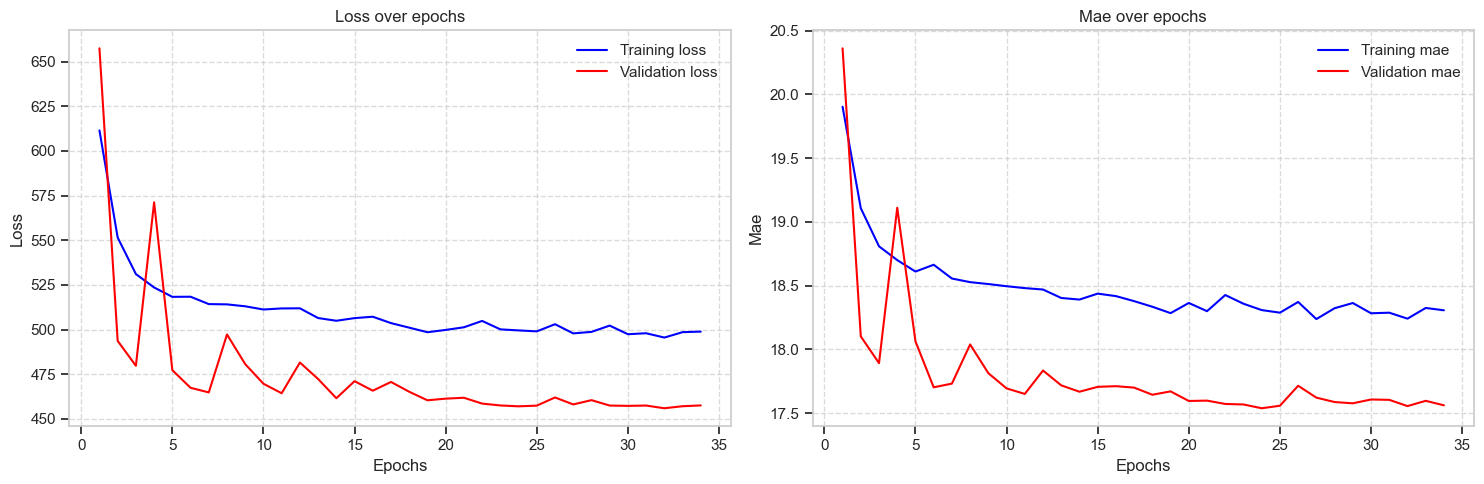

In [13]:
# Plot training history - FIXED TO HANDLE KERAS HISTORY OBJECT
# The previous call was causing TypeError: argument of type 'History' is not iterable
# because History object needs to use .history attribute to access metrics

# Modified version of plot_training_history function
def plot_history(history_obj, metrics):
    """
    Plot training history from Keras History object
    
    Args:
        history_obj: Keras History object returned from model.fit()
        metrics: List of metrics to plot
    """
    history = history_obj.history  # Access the dictionary inside History object
    epochs = range(1, len(history[list(history.keys())[0]]) + 1)
    
    plt.figure(figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        
        # Plot training metric
        if metric in history:
            plt.plot(epochs, history[metric], 'b-', label=f'Training {metric}')
            
        # Plot validation metric
        val_metric = f'val_{metric}'
        if val_metric in history:
            plt.plot(epochs, history[val_metric], 'r-', label=f'Validation {metric}')
            
        plt.title(f'{metric.capitalize()} over epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Use the fixed function to plot training history
plot_history(age_history, ['loss', 'mae'])

In [14]:
# PERUBAHAN 5: EVALUASI MODEL BERDASARKAN KELOMPOK USIA
# Evaluate the model on test data
age_evaluation = age_model.evaluate(test_age_dataset)
print(f"Test Loss: {age_evaluation[0]:.4f}")
print(f"Test MAE: {age_evaluation[1]:.4f} years")

# Make predictions on test data
age_predictions = []
age_true = []
test_images = []
test_features = []

for images, labels in test_age_dataset:
    batch_predictions = age_model.predict(images)
    age_predictions.extend(batch_predictions.flatten())
    age_true.extend(labels.numpy())
    # Simpan beberapa gambar untuk visualisasi
    if len(test_images) < 50:  # Batasi jumlah gambar yang disimpan
        test_images.extend([img.numpy() for img in images])

# Convert to numpy arrays
age_predictions = np.array(age_predictions)
age_true = np.array(age_true)

115/115 [==============================] - 16s 134ms/step - loss: 461.4338 - mae: 17.6041
Test Loss: 461.4338
Test MAE: 17.6041 years
1/1 [==============================] - 1s 934ms/step


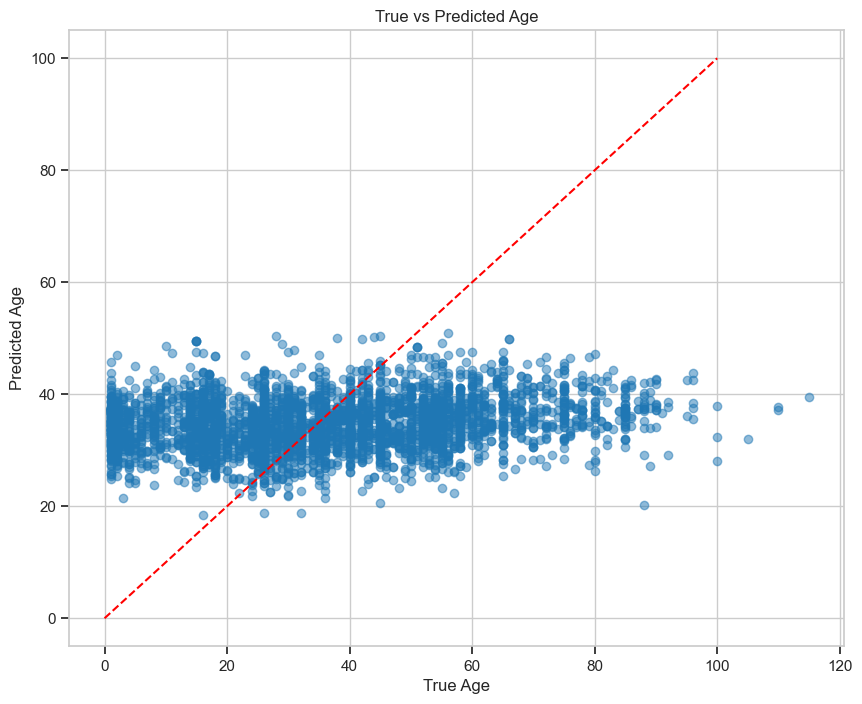

Mean Absolute Error: 17.60 years
Mean Squared Error: 461.43
Root Mean Squared Error: 21.48 years


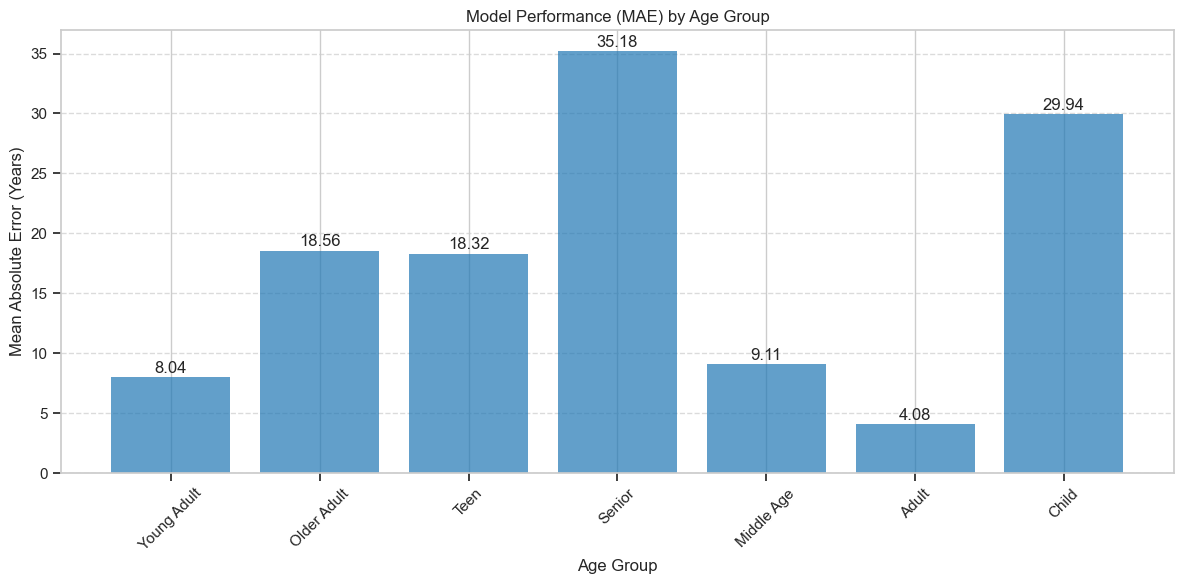

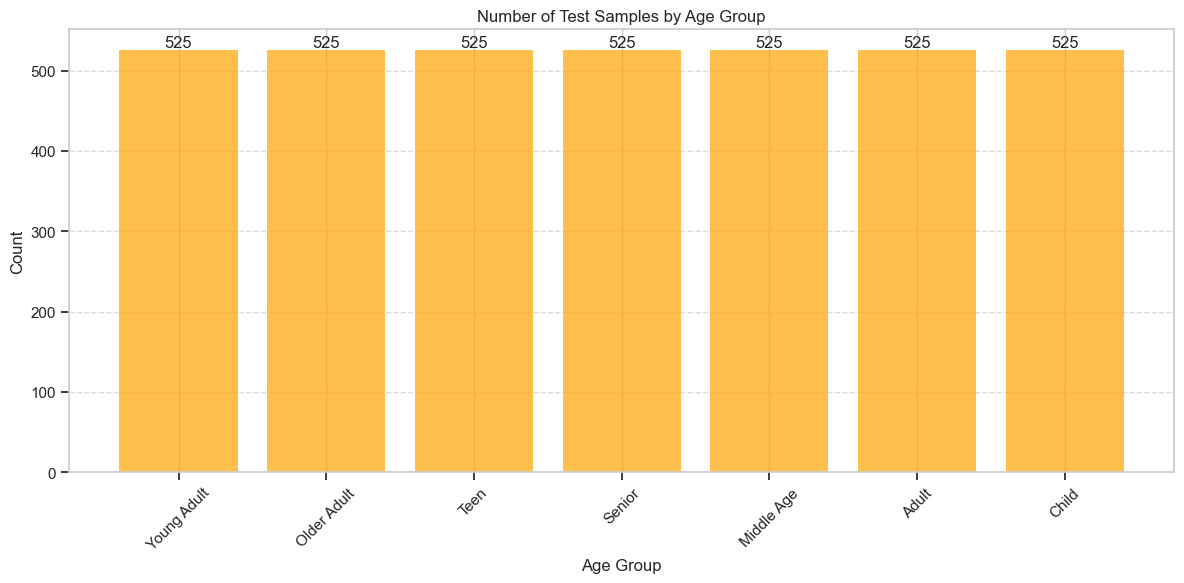

In [15]:
# Plot true vs predicted ages
plt.figure(figsize=(10, 8))
plt.scatter(age_true, age_predictions, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')
plt.title('True vs Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True)
plt.show()

# Calculate error metrics
mae = mean_absolute_error(age_true, age_predictions)
mse = np.mean((age_true - age_predictions) ** 2)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f} years")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f} years")

# Evaluate model performance by age group
def evaluate_by_age_group(true_ages, pred_ages, test_df):
    """Evaluasi model berdasarkan kelompok usia"""
    # Menggunakan age_group yang sudah didefinisikan dalam dataframe
    group_metrics = {}
    
    for group in test_df['age_group'].unique():
        # Ambil indeks untuk kelompok ini
        group_indices = test_df['age_group'] == group
        
        if sum(group_indices) > 0:
            # Cari MAE untuk kelompok ini
            group_true = true_ages[group_indices]
            group_pred = pred_ages[group_indices]
            group_mae = mean_absolute_error(group_true, group_pred)
            
            group_metrics[group] = {
                'mae': group_mae,
                'count': sum(group_indices),
                'mean_age': np.mean(group_true)
            }
    
    return group_metrics

# Dapatkan evaluasi per kelompok usia
# Perlu adjustment karena kita bekerja dengan dataset tf.data
# Reindex pred dan true untuk mencocokkannya dengan test_df
age_group_metrics = evaluate_by_age_group(age_true[:len(test_df)], age_predictions[:len(test_df)], test_df)

# Visualisasi performa model per kelompok usia
groups = list(age_group_metrics.keys())
mae_values = [age_group_metrics[g]['mae'] for g in groups]
counts = [age_group_metrics[g]['count'] for g in groups]

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
bars = ax.bar(groups, mae_values, alpha=0.7)

# Tambahkan label nilai MAE di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{mae_values[i]:.2f}',
            ha='center', va='bottom')

plt.title('Model Performance (MAE) by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Absolute Error (Years)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualisasi distribusi jumlah sampel per kelompok
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
bars = ax.bar(groups, counts, alpha=0.7, color='orange')

# Tambahkan label jumlah sampel di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{counts[i]}',
            ha='center', va='bottom')

plt.title('Number of Test Samples by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

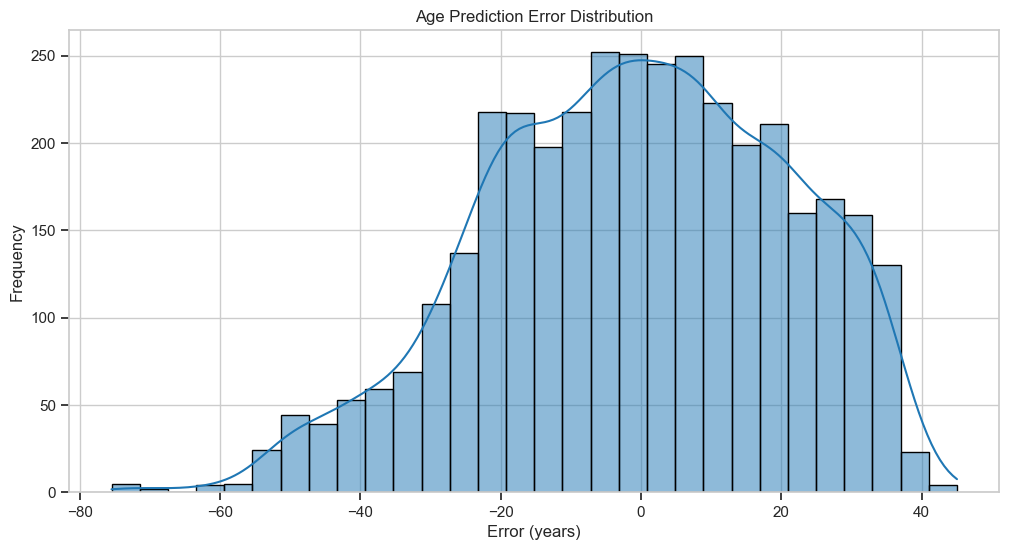


Summary Statistics:
{'count': 3675, 'mean': -0.9384272153685693, 'std': 21.46050172609724, 'min': -75.47666549682617, '25%': -16.376842498779297, '50%': -0.20631027221679688, '75%': 15.918819427490234, 'max': 45.024723052978516}


In [16]:
# Plot error distribution
errors = age_predictions - age_true
plot_distribution(errors, title="Age Prediction Error Distribution", 
                 xlabel="Error (years)", ylabel="Frequency")

In [17]:
# Save the age model
age_model.save(AGE_MODEL_PATH)
print(f"Age model saved to {AGE_MODEL_PATH}")

2025-03-21 12:45:04,163 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:04,271 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:04,357 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:04,424 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:04,551 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:04,611 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:04,655 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:04,703 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:05,231 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:05,265 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:05,305 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:05,337 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 12:45:05,389 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 12:45:05,425 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:05,525 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 12:45:05,677 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:05,712 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:05,751 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:05,823 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:06,107 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:06,154 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:06,194 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:06,224 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:06,430 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:06,609 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:06,637 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:06,680 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:06,712 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:07,024 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:17,644 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:17,676 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:17,708 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:17,735 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:17,999 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:18,097 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:18,125 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,159 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,181 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:18,328 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:18,392 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:18,417 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,453 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,485 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:18,665 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:18,707 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,737 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:18,764 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 12:45:18,820 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 12:45:18,855 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:18,920 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 12:45:19,010 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:19,036 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:19,064 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:19,089 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:19,144 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:19,173 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:19,202 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:19,227 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:20,311 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:20,346 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:20,378 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:20,400 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:20,618 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:20,743 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:20,795 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:20,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:20,874 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:21,043 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:21,101 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:21,126 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,180 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:21,325 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:21,351 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,382 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,407 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 12:45:21,447 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 12:45:21,474 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:21,535 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 12:45:21,619 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:21,644 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,675 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,699 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:21,756 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:21,795 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,832 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:21,872 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:23,768 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:23,793 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:23,831 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:23,865 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:24,089 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:24,174 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:24,207 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,239 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,260 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:24,400 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:24,451 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:24,480 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,507 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,527 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:24,655 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:24,677 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,702 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:24,721 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 12:45:24,756 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 12:45:24,780 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:24,834 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 12:45:24,942 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:24,967 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:25,003 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:25,029 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:25,084 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:25,110 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:25,139 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:25,164 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:28,336 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:28,360 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:28,388 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:28,409 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:28,611 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:28,761 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:28,784 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:28,809 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:28,830 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:28,959 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 12:45:29,102 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:29,130 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,164 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,196 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:29,408 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:29,431 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,457 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,478 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 12:45:29,516 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 12:45:29,541 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:29,595 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 12:45:29,725 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:29,749 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,772 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,793 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 12:45:29,835 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 12:45:29,860 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,886 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 12:45:29,907 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 12:45:30,309 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\assets


2025-03-21 12:45:34,815 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model\assets


Age model saved to D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model


## 5. Gender Model Development

Now, let's build and train the gender classification model.

In [18]:
# Create binary gender labels (0: male, 1: female)
train_df['gender_binary'] = train_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
val_df['gender_binary'] = val_df['gender'].apply(lambda x: 1 if x == 'female' else 0)
test_df['gender_binary'] = test_df['gender'].apply(lambda x: 1 if x == 'female' else 0)

In [19]:
# Create TensorFlow datasets for gender prediction
def preprocess_for_gender(image):
    # This function can be used to apply additional preprocessing for gender prediction
    return image

batch_size = gender_config['training']['batch_size']

# Create datasets
train_gender_dataset = create_tf_dataset_from_dataframe(
    train_df, 
    'path', 
    'gender_binary',
    preprocess_fn=preprocess_for_gender,
    batch_size=batch_size
)

val_gender_dataset = create_tf_dataset_from_dataframe(
    val_df, 
    'path', 
    'gender_binary',
    preprocess_fn=preprocess_for_gender,
    batch_size=batch_size,
    shuffle=False
)

test_gender_dataset = create_tf_dataset_from_dataframe(
    test_df, 
    'path', 
    'gender_binary',
    preprocess_fn=preprocess_for_gender,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
# Define data augmentation for gender model
if gender_config['augmentation']['enabled']:
    gender_data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(gender_config['augmentation']['rotation_range'] / 360.0),
        layers.RandomZoom(gender_config['augmentation']['zoom_range']),
        layers.RandomBrightness(
            (gender_config['augmentation']['brightness_range'][0] - 1.0,
             gender_config['augmentation']['brightness_range'][1] - 1.0)
        )
    ])

In [21]:
# ENHANCED GENDER MODEL - with improved architecture and data augmentation
def create_gender_model(input_shape=(200, 200, 3)):
    """
    Create an enhanced gender classification model using transfer learning
    with MobileNetV2 as the base model.
    """
    # Data Augmentation Layer (use the same one for simplicity)
    preprocessing_model = create_age_preprocessing_model(input_shape)
    
    # Base model (MobileNetV2)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Model architecture
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocessing_model(inputs)
    # Use MobileNetV2's preprocessing
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    # Pass through base model
    x = base_model(x, training=False)
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    # Add batch normalization for more stable training
    x = layers.BatchNormalization()(x)
    # First dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    # Second dense layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # Output layer (binary classification)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = tf.keras.Model(inputs, outputs, name="gender_model")
    
    # Compile model with proper loss and metrics for binary classification
    model.compile(
        optimizer=optimizers.Adam(learning_rate=gender_config['training']['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]  # Add AUC for better evaluation
    )

    return model

# Create the enhanced gender model
gender_model = create_gender_model(input_shape=tuple(gender_config['input_shape']))
gender_model.summary()

2025-03-21 13:20:20,380 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:20,411 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:20,456 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:20,514 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:20,884 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:20,993 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:21,018 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,057 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,112 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:21,377 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:21,454 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:21,487 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,516 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,543 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:21,764 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:21,790 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,817 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:21,844 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:20:21,888 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:20:21,914 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:21,984 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:20:22,081 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:22,107 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:23,541 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:23,565 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:23,612 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:23,634 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:23,657 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:23,675 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:23,920 - tensorflow - WARNING - `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Model: "gender_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 age_preprocessing (Function  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                               

In [22]:
# PERUBAHAN 4: CALLBACKS YANG LEBIH KOMPREHENSIF UNTUK MODEL GENDER
# Define callbacks for training dengan fitur tambahan
gender_callbacks = [
    callbacks.EarlyStopping(
        patience=gender_config['training']['early_stopping_patience'],
        restore_best_weights=True,
        monitor='val_accuracy'
    ),
    callbacks.ModelCheckpoint(
        filepath=f"{GENDER_MODEL_PATH}/checkpoint",
        save_best_only=True,
        monitor='val_accuracy'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    # Tambahkan TensorBoard untuk visualisasi training
    callbacks.TensorBoard(
        log_dir=f"{GENDER_MODEL_PATH}/logs",
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    ),
    # Tambahkan CSV Logger untuk menyimpan metrik training
    callbacks.CSVLogger(
        f"{GENDER_MODEL_PATH}/training_log.csv",
        separator=',',
        append=False
    )
]

print("✅ Callbacks untuk model gender telah ditingkatkan")

✅ Callbacks untuk model gender telah ditingkatkan


In [23]:
# Train the model
gender_history = gender_model.fit(
    train_gender_dataset,
    validation_data=val_gender_dataset,
    epochs=gender_config['training']['epochs'],
    callbacks=gender_callbacks,
    verbose=1
)

Epoch 1/30


2025-03-21 13:20:35,442 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:35,492 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:35,531 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:35,558 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:35,924 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:36,075 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:36,169 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:36,219 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:36,269 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:36,566 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:36,692 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:36,725 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:36,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:36,792 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:36,967 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:36,997 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,030 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,058 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:20:37,115 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:20:37,153 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:37,226 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:20:37,325 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:37,350 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,391 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,425 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:37,508 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:37,544 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,581 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:37,610 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:39,282 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:39,308 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:39,337 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:39,362 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:39,627 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:39,734 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:39,764 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:39,799 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:39,822 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:39,974 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:20:40,029 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:40,054 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,081 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,104 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:40,249 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:40,275 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,303 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,329 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:20:40,371 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:20:40,399 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:40,464 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:20:40,551 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:40,575 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,603 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,632 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:20:40,702 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:20:40,731 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:20:40,791 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


536/536 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7685 - auc: 0.8482WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:03,590 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:03,613 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:03,643 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:03,670 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:03,731 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:03,774 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:03,810 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:03,836 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:04,149 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:04,176 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,205 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,230 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:26:04,267 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:26:04,297 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:04,355 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:26:04,476 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:04,502 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,531 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,554 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:04,763 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:04,792 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,847 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:04,901 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:05,090 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:05,240 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:05,265 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:05,291 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:05,315 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:05,535 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:14,656 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:14,686 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:14,716 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:14,742 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:14,961 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:15,055 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:15,089 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,124 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,149 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:15,316 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:15,391 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:15,423 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,464 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,493 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:15,641 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:15,668 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,699 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:15,730 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:26:15,773 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:26:15,804 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:15,874 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:26:15,968 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:15,995 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:16,023 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:16,045 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:16,101 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:16,127 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:16,156 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:16,179 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:17,195 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:17,219 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:17,248 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:17,284 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:17,553 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:17,644 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:17,673 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:17,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:17,729 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:17,881 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:17,939 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:17,965 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,007 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,037 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:18,184 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:18,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,241 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,266 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:26:18,309 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:26:18,336 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:18,403 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:26:18,529 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:18,560 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,595 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,620 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:18,675 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:18,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,731 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:18,758 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:21,323 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:21,350 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:21,381 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:21,412 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:21,673 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:21,773 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:21,804 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:21,833 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:21,857 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:22,007 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:22,068 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:22,095 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,124 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:22,293 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:22,320 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,351 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,379 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:26:22,431 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:26:22,465 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:22,538 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:26:22,632 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:22,667 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,713 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,743 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:22,804 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:22,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,874 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:22,903 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:25,896 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:25,923 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:25,961 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:25,985 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:26,213 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:26,374 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:26,404 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:26,440 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:26,469 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:26,615 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:26:26,734 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:26,761 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:26,791 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:26,813 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:27,059 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:27,095 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,124 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,151 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:26:27,218 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:26:27,260 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:27,324 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:26:27,499 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:27,526 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,566 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,594 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:26:27,678 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:26:27,709 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,739 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:26:27,764 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 13:26:28,217 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 13:26:33,692 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 362s 629ms/step - loss: 0.4901 - accuracy: 0.7685 - auc: 0.8482 - val_loss: 0.3304 - val_accuracy: 0.8590 - val_auc: 0.9342 - lr: 0.0010
Epoch 2/30
536/536 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8013 - auc: 0.8823WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:54,175 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:54,212 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,258 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,301 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:54,356 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:54,391 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,431 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,464 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:54,787 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:54,814 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,845 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:54,870 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:31:54,908 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:31:54,936 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:55,002 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:31:55,129 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:55,158 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,192 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,216 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:55,483 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:55,511 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,544 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,572 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:55,733 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:31:55,910 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:31:55,937 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,970 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:31:55,997 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:31:56,222 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:06,576 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:06,606 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:06,638 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:06,662 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:06,926 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:07,031 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:07,059 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,093 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,117 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:07,268 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:07,326 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:07,352 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,382 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,405 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:07,559 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:07,586 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,619 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,650 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:32:07,690 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:32:07,720 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:07,783 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:32:07,887 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:07,912 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,957 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:07,990 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:08,056 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:08,085 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:08,119 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:08,147 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:09,218 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:09,294 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:09,346 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:09,373 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:09,592 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:09,678 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:09,707 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:09,738 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:09,763 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:09,914 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:09,970 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:09,997 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,038 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,080 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:10,246 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:10,275 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,303 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,328 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:32:10,374 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:32:10,405 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:10,476 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:32:10,567 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:10,594 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,623 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,648 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:10,699 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:10,727 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,761 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:10,789 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:12,839 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:12,870 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:12,901 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:12,926 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:13,138 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:13,241 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:13,283 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,320 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,345 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:13,516 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:13,577 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:13,606 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,636 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,662 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:13,817 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:13,845 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,874 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:13,897 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:32:13,943 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:32:13,969 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:14,036 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:32:14,129 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:14,155 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:14,182 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:14,206 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:14,275 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:14,318 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:14,350 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:14,377 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:17,824 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:17,851 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:17,879 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:17,905 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:18,122 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:18,280 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:18,307 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:18,335 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:18,360 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:18,566 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:32:18,688 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:18,715 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:18,744 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:18,768 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:18,946 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:18,972 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,003 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,025 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:32:19,063 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:32:19,093 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:19,156 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:32:19,293 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:19,320 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,347 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,371 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:32:19,425 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:32:19,474 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,523 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:32:19,551 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 13:32:19,998 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 13:32:25,161 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 351s 642ms/step - loss: 0.4296 - accuracy: 0.8013 - auc: 0.8823 - val_loss: 0.3204 - val_accuracy: 0.8642 - val_auc: 0.9411 - lr: 0.0010
Epoch 3/30
536/536 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8020 - auc: 0.8860WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:43,765 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:43,796 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:43,836 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:43,871 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:43,935 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:43,973 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,035 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,089 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:44,444 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:44,477 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,521 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,548 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:37:44,590 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:37:44,620 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:44,691 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:37:44,832 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:44,885 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,924 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:44,966 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:45,241 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:45,288 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:45,345 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:45,389 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:45,626 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:37:45,823 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:45,851 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:45,885 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:45,911 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:46,167 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:37:58,437 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:58,473 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:58,511 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:58,551 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:58,793 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:37:58,899 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:58,928 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:58,964 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:58,992 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:59,194 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:37:59,259 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:59,290 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,319 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,346 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:59,501 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:59,536 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,566 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,591 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:37:59,633 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:37:59,664 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:59,730 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:37:59,825 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:59,851 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,879 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:37:59,904 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:37:59,955 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:37:59,980 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:00,013 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:00,045 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:01,128 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:01,166 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:01,217 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:01,251 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:01,491 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:01,602 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:01,635 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:01,680 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:01,723 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:01,959 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:02,067 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:02,111 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,145 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,176 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:02,404 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:02,443 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,485 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,515 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:38:02,558 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:38:02,589 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:02,657 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:38:02,752 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:02,778 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,808 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,830 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:02,884 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:02,914 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,946 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:02,971 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:05,171 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:05,214 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:05,255 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:05,281 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:05,597 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:05,683 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:05,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:05,749 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:05,775 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:05,931 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:05,993 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:06,020 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,052 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,079 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:06,243 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:06,269 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,301 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,335 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:38:06,401 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:38:06,451 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:06,539 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:38:06,655 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:06,692 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,721 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,757 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:06,813 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:06,846 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,880 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:06,912 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:10,839 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:10,891 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:10,955 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:11,003 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:11,271 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:11,448 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:11,479 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,091 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,126 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:12,313 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:38:12,471 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:12,508 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,553 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,579 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:12,816 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:12,851 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,888 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:12,915 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:38:12,959 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:38:12,992 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:13,061 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:38:13,216 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:13,242 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:13,271 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:13,297 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:38:13,357 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:38:13,387 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:13,423 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:38:13,455 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 13:38:13,925 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 13:38:19,064 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 354s 646ms/step - loss: 0.4213 - accuracy: 0.8020 - auc: 0.8860 - val_loss: 0.3078 - val_accuracy: 0.8713 - val_auc: 0.9429 - lr: 0.0010
Epoch 4/30
536/536 [==============================] - 335s 607ms/step - loss: 0.4082 - accuracy: 0.8165 - auc: 0.8945 - val_loss: 0.3020 - val_accuracy: 0.8713 - val_auc: 0.9449 - lr: 0.0010
Epoch 5/30
536/536 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8162 - auc: 0.9000WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:21,899 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:21,928 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:21,957 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:21,983 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:22,069 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:22,101 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:22,138 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:22,167 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:22,481 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:22,546 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:22,601 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:22,630 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:49:22,680 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:49:22,714 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:22,782 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:49:22,931 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:22,971 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,013 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,053 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:23,276 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:23,305 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,336 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,365 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:23,514 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:23,747 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:23,780 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,815 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:23,843 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:24,084 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:35,219 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:35,249 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:35,288 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:35,317 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:35,551 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:35,634 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:35,662 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:35,692 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:35,718 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:35,868 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:35,930 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:35,956 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:35,986 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:36,010 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:36,183 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:36,226 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:36,259 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:36,298 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:49:36,355 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:49:36,384 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:36,459 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:49:36,563 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:36,590 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:36,621 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:37,057 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:37,109 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:37,138 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:37,173 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:37,200 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:38,225 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:38,253 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:38,286 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:38,322 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:38,599 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:38,699 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:38,728 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:38,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:38,786 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:38,939 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:39,005 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:39,031 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,060 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,085 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:39,239 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:39,266 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,298 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,328 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:49:39,383 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:49:39,435 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:39,529 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:49:39,648 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:39,679 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,711 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,742 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:39,803 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:39,835 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,868 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:39,893 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:41,960 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:41,993 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,023 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,046 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:42,266 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:42,358 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:42,387 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,420 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,445 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:42,725 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:42,791 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:42,822 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,857 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:42,881 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:43,032 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:43,057 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,088 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,118 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:49:43,171 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:49:43,206 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:43,272 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:49:43,375 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:43,403 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,432 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,458 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:43,515 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:43,544 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:43,608 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:46,823 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:46,870 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:46,909 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:46,940 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:47,175 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:47,344 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:47,372 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:47,405 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:47,432 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:47,605 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 13:49:47,733 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:47,764 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:47,795 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:47,823 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:48,065 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:48,093 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,130 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,160 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 13:49:48,208 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 13:49:48,240 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:48,311 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 13:49:48,467 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:48,506 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,539 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,576 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 13:49:48,633 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 13:49:48,663 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,695 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 13:49:48,723 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 13:49:49,174 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 13:49:55,748 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 362s 659ms/step - loss: 0.3968 - accuracy: 0.8162 - auc: 0.9000 - val_loss: 0.2971 - val_accuracy: 0.8767 - val_auc: 0.9478 - lr: 0.0010
Epoch 6/30
536/536 [==============================] - 334s 606ms/step - loss: 0.3937 - accuracy: 0.8211 - auc: 0.9020 - val_loss: 0.3075 - val_accuracy: 0.8710 - val_auc: 0.9476 - lr: 0.0010
Epoch 7/30
536/536 [==============================] - 328s 595ms/step - loss: 0.3894 - accuracy: 0.8250 - auc: 0.9048 - val_loss: 0.3072 - val_accuracy: 0.8650 - val_auc: 0.9471 - lr: 0.0010
Epoch 8/30
536/536 [==============================] - 332s 604ms/step - loss: 0.3879 - accuracy: 0.8251 - auc: 0.9051 - val_loss: 0.2911 - val_accuracy: 0.8756 - val_auc: 0.9497 - lr: 0.0010
Epoch 9/30
536/536 [==============================] - 301s 549ms/step - loss: 0.3877 - accuracy: 0.8282 - auc: 0.9066 - val_loss: 0.2936 - val_accuracy: 0.8716 - val_auc: 0.9493 - lr: 0.0010
Epoch 10/30
536/536 [==============================] - E

2025-03-21 14:16:31,000 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:31,027 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,056 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,077 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:31,125 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:31,153 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,180 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,201 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:31,485 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:31,510 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,537 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,569 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:16:31,623 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:16:31,658 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:31,726 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:16:31,856 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:31,879 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,910 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:31,933 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:32,123 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:32,146 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:32,174 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:32,196 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:32,327 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:32,469 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:32,494 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:32,521 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:32,543 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:32,778 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:42,052 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:42,075 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,110 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,145 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:42,365 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:42,447 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:42,473 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,512 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,541 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:42,689 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:42,745 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:42,772 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,798 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:42,820 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:42,953 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:42,978 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,009 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,035 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:16:43,083 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:16:43,114 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:43,185 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:16:43,305 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:43,328 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,360 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,384 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:43,433 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:43,458 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,485 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:43,508 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:44,445 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:44,469 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:44,498 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:44,520 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:44,730 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:44,810 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:44,840 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:44,866 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:44,888 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:45,025 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:45,082 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:45,108 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,135 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,157 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:45,303 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:45,328 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,370 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,405 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:16:45,451 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:16:45,482 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:45,547 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:16:45,631 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:45,662 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,690 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,712 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:45,757 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:45,783 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,814 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:45,843 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:48,054 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:48,077 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,109 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,132 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:48,322 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:48,401 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:48,427 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,459 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,498 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:48,672 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:48,733 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:48,761 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,791 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:48,815 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:48,962 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:48,987 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,015 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,038 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:16:49,081 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:16:49,113 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:49,171 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:16:49,256 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:49,280 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,306 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,329 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:49,375 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:49,402 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,432 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:49,457 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:52,201 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:52,225 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:52,253 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:52,276 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:52,484 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:52,658 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:52,698 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:52,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:52,759 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:52,905 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:16:53,019 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:53,048 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,080 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,108 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:53,286 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:53,310 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,341 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,366 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:16:53,410 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:16:53,445 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:53,507 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:16:53,665 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:53,695 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,736 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,772 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:16:53,834 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:16:53,864 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:16:53,922 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 14:16:54,369 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 14:16:59,983 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 329s 601ms/step - loss: 0.3789 - accuracy: 0.8313 - auc: 0.9102 - val_loss: 0.2909 - val_accuracy: 0.8776 - val_auc: 0.9493 - lr: 0.0010
Epoch 11/30
536/536 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8335 - auc: 0.9122WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:21:59,701 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:21:59,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:21:59,768 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:21:59,795 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:21:59,855 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:21:59,880 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:21:59,914 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:21:59,939 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:00,230 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:00,256 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,282 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,308 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:22:00,345 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:22:00,375 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:00,443 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:22:00,594 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:00,623 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,650 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,674 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:00,915 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:00,939 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,967 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:00,989 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:01,131 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:01,286 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:01,315 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:01,343 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:01,366 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:01,587 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:11,056 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:11,091 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,125 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,153 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:11,367 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:11,449 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:11,481 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,508 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,530 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:11,660 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:11,714 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:11,741 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,766 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,790 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:11,926 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:11,952 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:11,979 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:12,001 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:22:12,040 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:22:12,081 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:12,167 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:22:12,278 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:12,306 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:12,337 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:12,364 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:12,417 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:12,447 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:12,478 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:12,503 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:13,423 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:13,446 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:13,476 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:13,499 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:13,707 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:13,791 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:13,819 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:13,853 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:13,875 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:14,050 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:14,104 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:14,137 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,184 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,217 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:14,363 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:14,387 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,412 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,434 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:22:14,473 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:22:14,500 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:14,560 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:22:14,644 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:14,674 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,708 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,733 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:14,785 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:14,810 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,838 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:14,862 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:16,626 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:16,650 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:16,678 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:16,702 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:16,918 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:16,995 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:17,021 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,048 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,071 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:17,200 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:17,255 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:17,293 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,332 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,358 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:17,501 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:17,528 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,558 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,583 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:22:17,623 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:22:17,648 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:17,710 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:22:17,799 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:17,822 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,854 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,881 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:17,928 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:17,953 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:17,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:18,005 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:20,559 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:20,583 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:20,614 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:20,637 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:20,848 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:20,991 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:21,015 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:21,042 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:21,064 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:21,194 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:22:21,306 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:21,333 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:21,883 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:21,906 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:22,083 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:22,106 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,130 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,157 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:22:22,195 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:22:22,222 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:22,288 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:22:22,420 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:22,450 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,480 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,508 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:22:22,594 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:22:22,622 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,653 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:22:22,676 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 14:22:23,070 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 14:22:27,643 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 328s 597ms/step - loss: 0.3755 - accuracy: 0.8335 - auc: 0.9122 - val_loss: 0.2907 - val_accuracy: 0.8784 - val_auc: 0.9510 - lr: 0.0010
Epoch 12/30
536/536 [==============================] - 304s 550ms/step - loss: 0.3700 - accuracy: 0.8327 - auc: 0.9136 - val_loss: 0.2904 - val_accuracy: 0.8759 - val_auc: 0.9508 - lr: 0.0010
Epoch 13/30
536/536 [==============================] - 305s 553ms/step - loss: 0.3701 - accuracy: 0.8386 - auc: 0.9146 - val_loss: 0.2844 - val_accuracy: 0.8776 - val_auc: 0.9512 - lr: 0.0010
Epoch 14/30
536/536 [==============================] - 305s 552ms/step - loss: 0.3713 - accuracy: 0.8380 - auc: 0.9146 - val_loss: 0.2873 - val_accuracy: 0.8759 - val_auc: 0.9511 - lr: 0.0010
Epoch 15/30
536/536 [==============================] - 307s 555ms/step - loss: 0.3658 - accuracy: 0.8398 - auc: 0.9166 - val_loss: 0.2808 - val_accuracy: 0.8776 - val_auc: 0.9523 - lr: 0.0010
Epoch 16/30
536/536 [==============================]

2025-03-21 14:47:57,559 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:57,584 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:57,618 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:57,643 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:57,694 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:57,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:57,746 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:57,768 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:58,057 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:58,083 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,108 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,130 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:47:58,167 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:47:58,193 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:58,251 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:47:58,367 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:58,399 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,437 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,469 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:58,672 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:58,699 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,727 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:58,746 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:58,882 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:47:59,023 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:47:59,048 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:59,080 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:47:59,105 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:47:59,302 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:09,085 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:09,118 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,154 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,184 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:09,427 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:09,538 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:09,570 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,603 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,629 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:09,788 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:09,859 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:09,894 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,935 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:09,966 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:10,172 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:10,206 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,240 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,274 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:48:10,327 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:48:10,355 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:10,416 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:48:10,503 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:10,527 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,555 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,578 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:10,630 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:10,662 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,705 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:10,727 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:12,101 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:12,132 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:12,183 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:12,228 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:12,446 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:12,550 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:12,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:12,610 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:12,639 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:12,829 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:12,913 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:12,949 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:12,977 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,008 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:13,200 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:13,254 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,294 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,321 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:48:13,380 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:48:13,429 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:13,497 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:48:13,591 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:13,623 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,656 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,693 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:13,748 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:13,778 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,814 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:13,840 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:15,666 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:15,690 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:15,720 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:15,743 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:15,948 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:16,023 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:16,047 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,077 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,102 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:16,236 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:16,300 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:16,338 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,378 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,405 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:16,549 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:16,577 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,605 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,630 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:48:16,671 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:48:16,697 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:16,758 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:48:16,840 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:16,865 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,897 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:16,923 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:16,980 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:17,009 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:17,037 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:17,062 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:19,863 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:19,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:19,930 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:19,956 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:20,171 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:20,326 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:20,352 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:20,384 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:20,409 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:20,591 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:48:20,721 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:20,747 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:20,776 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:20,801 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:20,982 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:21,011 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,041 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,064 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:48:21,104 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:48:21,132 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:21,204 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:48:21,368 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:21,395 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,425 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,452 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:48:21,510 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:48:21,542 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,577 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:48:21,613 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 14:48:22,047 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 14:48:27,343 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 338s 613ms/step - loss: 0.3665 - accuracy: 0.8381 - auc: 0.9160 - val_loss: 0.2809 - val_accuracy: 0.8789 - val_auc: 0.9527 - lr: 0.0010
Epoch 17/30
536/536 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8433 - auc: 0.9212WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:33,211 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:33,237 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,270 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,294 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:33,344 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:33,369 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,399 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,422 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:33,725 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:33,753 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,785 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:33,813 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:53:33,859 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:53:33,911 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:33,997 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:53:34,132 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:34,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,185 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,213 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:34,422 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:34,448 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,476 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,497 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:34,625 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:34,764 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:34,790 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,818 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:34,840 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:35,078 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:44,285 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:44,315 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:44,363 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:44,397 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:44,610 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:44,683 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:44,708 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:44,737 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:44,760 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:44,894 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:44,953 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:44,976 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,003 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,026 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:45,159 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:45,185 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,236 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:53:45,275 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:53:45,302 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:45,391 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:53:45,503 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:45,534 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,564 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,586 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:45,639 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:45,664 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,689 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:45,714 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:46,619 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:46,643 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:46,670 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:46,694 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:46,890 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:46,974 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:46,998 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,025 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,048 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:47,186 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:47,240 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:47,264 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,289 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,312 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:47,456 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:47,494 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,527 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,553 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:53:47,596 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:53:47,641 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:47,706 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:53:47,788 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:47,818 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,849 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,872 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:47,921 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:47,954 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:47,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:48,005 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:49,816 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:49,848 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:49,889 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:49,919 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:50,128 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:50,206 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:50,231 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,257 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,278 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:50,411 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:50,465 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:50,488 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,515 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,539 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:50,702 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:50,730 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,759 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:50,779 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:53:50,820 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:53:50,849 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:51,333 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:53:51,420 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:51,448 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:51,483 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:51,504 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:51,552 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:51,575 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:51,615 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:51,651 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:54,309 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:54,338 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:54,377 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:54,404 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:54,612 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:54,803 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:54,832 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:54,862 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:54,893 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:55,034 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 14:53:55,151 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:55,176 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,207 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,244 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:55,459 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:55,486 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,519 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,545 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 14:53:55,582 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 14:53:55,611 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:55,671 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 14:53:55,854 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:55,881 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,913 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:55,943 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 14:53:55,999 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 14:53:56,028 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:56,062 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 14:53:56,085 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 14:53:56,469 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 14:54:01,398 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 334s 608ms/step - loss: 0.3549 - accuracy: 0.8433 - auc: 0.9212 - val_loss: 0.2901 - val_accuracy: 0.8835 - val_auc: 0.9526 - lr: 0.0010
Epoch 18/30
536/536 [==============================] - 311s 564ms/step - loss: 0.3624 - accuracy: 0.8382 - auc: 0.9181 - val_loss: 0.2858 - val_accuracy: 0.8833 - val_auc: 0.9520 - lr: 0.0010
Epoch 19/30
536/536 [==============================] - 320s 581ms/step - loss: 0.3575 - accuracy: 0.8422 - auc: 0.9206 - val_loss: 0.2816 - val_accuracy: 0.8824 - val_auc: 0.9531 - lr: 5.0000e-04
Epoch 20/30
536/536 [==============================] - 320s 581ms/step - loss: 0.3507 - accuracy: 0.8440 - auc: 0.9231 - val_loss: 0.2800 - val_accuracy: 0.8814 - val_auc: 0.9531 - lr: 5.0000e-04
Epoch 21/30
536/536 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8474 - auc: 0.9262WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:18,945 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:18,979 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,013 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,036 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:19,090 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:19,115 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,142 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,166 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:19,454 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:19,494 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,544 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,582 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 15:15:19,627 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 15:15:19,656 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:19,737 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 15:15:19,880 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:19,912 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,941 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:19,974 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:20,191 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:20,220 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:20,250 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:20,274 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:20,409 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:20,581 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:20,615 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:20,647 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:20,675 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:20,880 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:29,951 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:29,977 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,012 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,042 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:30,298 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:30,382 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:30,407 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,439 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,464 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:30,621 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:30,675 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:30,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,731 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,759 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:30,899 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:30,924 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,956 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:30,982 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 15:15:31,032 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 15:15:31,064 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:31,134 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 15:15:31,263 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:31,293 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:31,326 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:31,355 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:31,423 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:31,450 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:31,483 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:31,512 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:32,525 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:32,554 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:32,584 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:32,608 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:32,828 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:32,913 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:32,939 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:32,968 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:32,995 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:33,171 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:33,236 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:33,263 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,312 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,357 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:33,528 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:33,557 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,591 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,625 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 15:15:33,678 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 15:15:33,707 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:33,776 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 15:15:33,863 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:33,891 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,922 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:33,946 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:34,003 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:34,035 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:34,072 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:34,096 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:36,425 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:36,463 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:36,504 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:36,534 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:36,762 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:36,846 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:36,876 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:36,903 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:36,928 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:37,084 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:37,142 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:37,169 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,201 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,228 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:37,376 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:37,403 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,444 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,496 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 15:15:37,555 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 15:15:37,587 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:37,664 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 15:15:37,753 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:37,781 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,816 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,854 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:37,916 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:37,946 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:37,981 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:38,011 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:40,889 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:40,912 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:40,941 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:40,965 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:41,190 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:41,349 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:41,374 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:41,406 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:41,430 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:41,574 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 15:15:41,708 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:41,733 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:41,765 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:41,795 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:41,982 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:42,008 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,040 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,070 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 15:15:42,109 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 15:15:42,141 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:42,209 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 15:15:42,368 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:42,398 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,432 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,460 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 15:15:42,559 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 15:15:42,601 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,639 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 15:15:42,670 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 15:15:43,123 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


2025-03-21 15:15:48,611 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\checkpoint\assets


536/536 [==============================] - 356s 646ms/step - loss: 0.3438 - accuracy: 0.8474 - auc: 0.9262 - val_loss: 0.2782 - val_accuracy: 0.8882 - val_auc: 0.9538 - lr: 5.0000e-04
Epoch 22/30
536/536 [==============================] - 319s 578ms/step - loss: 0.3452 - accuracy: 0.8501 - auc: 0.9267 - val_loss: 0.2811 - val_accuracy: 0.8830 - val_auc: 0.9532 - lr: 5.0000e-04
Epoch 23/30
536/536 [==============================] - 322s 584ms/step - loss: 0.3460 - accuracy: 0.8465 - auc: 0.9258 - val_loss: 0.2848 - val_accuracy: 0.8811 - val_auc: 0.9535 - lr: 5.0000e-04
Epoch 24/30
536/536 [==============================] - 318s 578ms/step - loss: 0.3392 - accuracy: 0.8516 - auc: 0.9283 - val_loss: 0.2874 - val_accuracy: 0.8854 - val_auc: 0.9539 - lr: 5.0000e-04
Epoch 25/30
536/536 [==============================] - 319s 579ms/step - loss: 0.3370 - accuracy: 0.8523 - auc: 0.9294 - val_loss: 0.2781 - val_accuracy: 0.8833 - val_auc: 0.9544 - lr: 2.5000e-04
Epoch 26/30
536/536 [===========

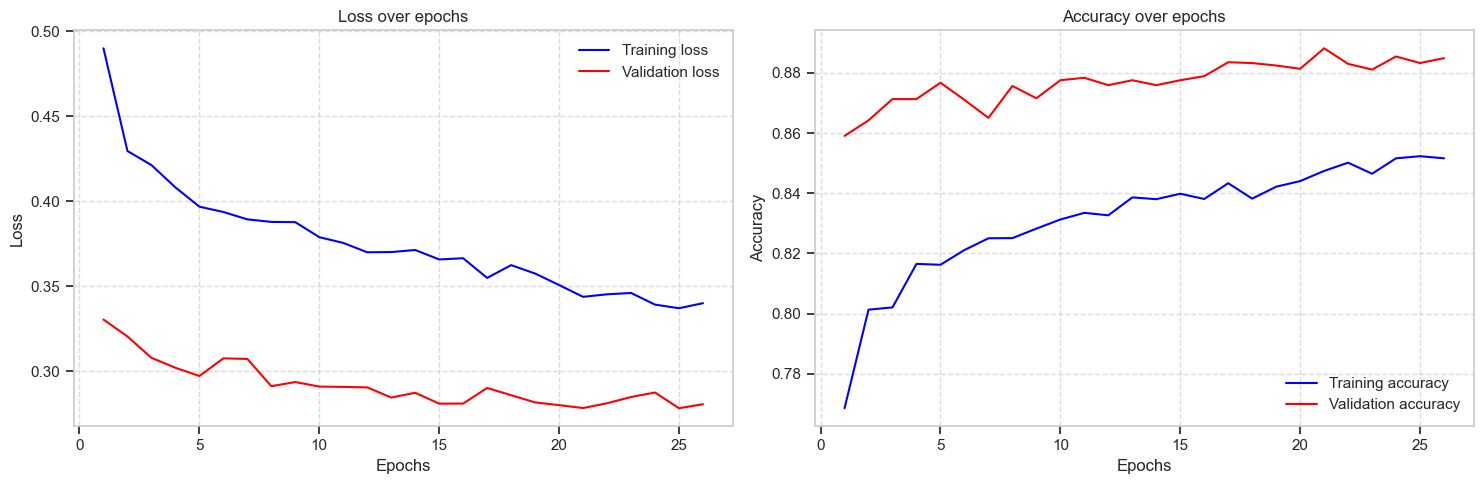

In [25]:
# Plot training history
plot_history(gender_history, ['loss', 'accuracy'])

In [26]:
# Evaluate the model on test data
gender_evaluation = gender_model.evaluate(test_gender_dataset)
print(f"Test Loss: {gender_evaluation[0]:.4f}")
print(f"Test Accuracy: {gender_evaluation[1]:.4f}")

115/115 [==============================] - 3s 25ms/step - loss: 0.2757 - accuracy: 0.8844 - auc: 0.9548
Test Loss: 0.2757
Test Accuracy: 0.8844


In [27]:
# Make predictions on test data
gender_predictions = []
gender_true = []

for images, labels in test_gender_dataset:
    batch_predictions = gender_model.predict(images)
    gender_predictions.extend(batch_predictions.flatten())
    gender_true.extend(labels.numpy())

# Convert to numpy arrays and binarize predictions
gender_predictions = np.array(gender_predictions)
gender_pred_classes = (gender_predictions > 0.5).astype(int)
gender_true = np.array(gender_true)

1/1 [==============================] - 1s 816ms/step


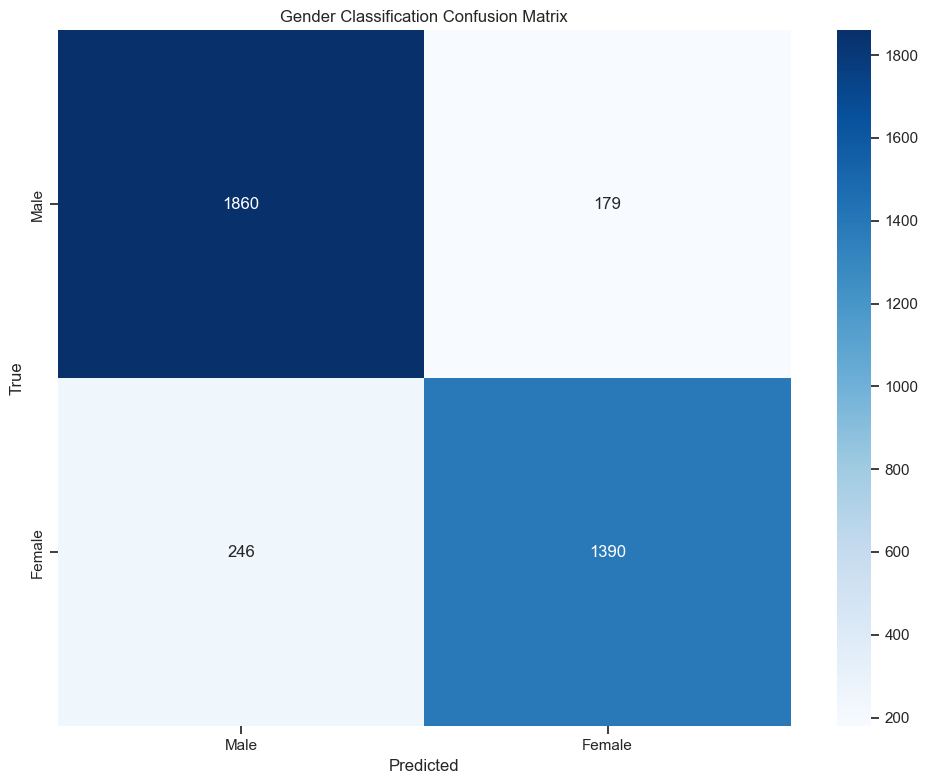


Classification Report:
              precision    recall  f1-score   support

        Male       0.88      0.91      0.90      2039
      Female       0.89      0.85      0.87      1636

    accuracy                           0.88      3675
   macro avg       0.88      0.88      0.88      3675
weighted avg       0.88      0.88      0.88      3675



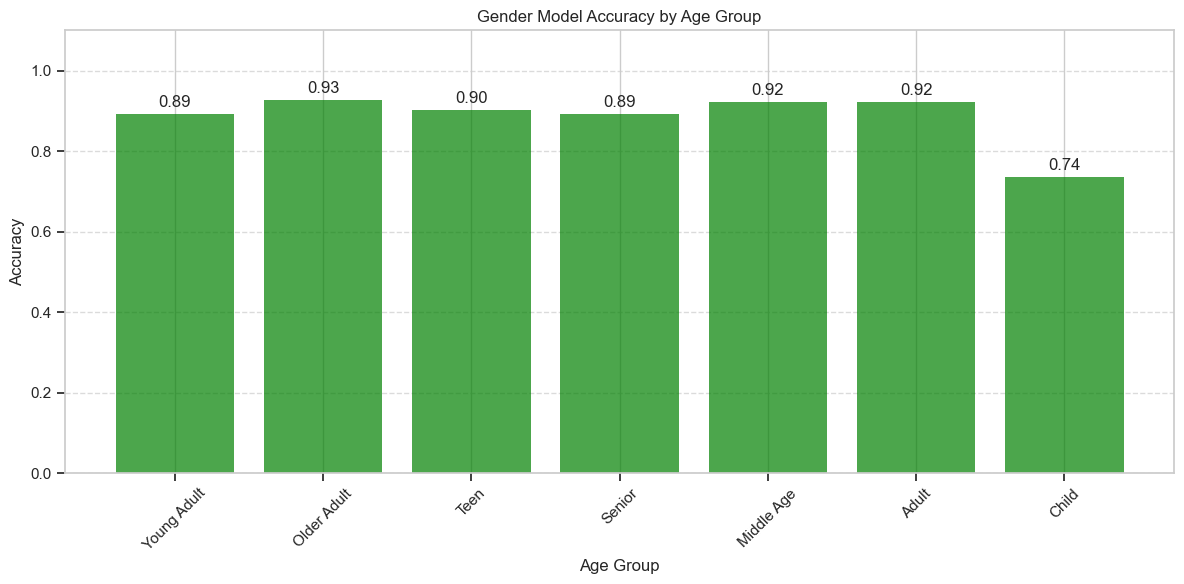

Overall Accuracy: 0.8844
Precision: 0.8859
Recall: 0.8496
F1 Score: 0.8674


In [28]:
# PERUBAHAN 5: EVALUASI MODEL GENDER BERDASARKAN KELOMPOK USIA
# Plot confusion matrix
class_names = ['Male', 'Female']
plot_confusion_matrix(
    gender_true, 
    gender_pred_classes, 
    class_names=class_names,
    title="Gender Classification Confusion Matrix"
)

# Evaluasi model gender berdasarkan kelompok usia
def evaluate_gender_by_age_group(true_gender, pred_gender, test_df):
    """Evaluasi akurasi gender berdasarkan kelompok usia"""
    group_metrics = {}
    
    for group in test_df['age_group'].unique():
        # Ambil indeks untuk kelompok ini
        group_indices = test_df['age_group'] == group
        
        if sum(group_indices) > 0:
            # Hitung akurasi untuk kelompok ini
            group_true = true_gender[group_indices]
            group_pred = pred_gender[group_indices]
            group_accuracy = np.mean(group_true == group_pred)
            
            group_metrics[group] = {
                'accuracy': group_accuracy,
                'count': sum(group_indices)
            }
    
    return group_metrics

# Evaluasi gender berdasarkan kelompok usia
gender_group_metrics = evaluate_gender_by_age_group(
    gender_true[:len(test_df)], 
    gender_pred_classes[:len(test_df)], 
    test_df
)

# Visualisasi akurasi gender berdasarkan kelompok usia
groups = list(gender_group_metrics.keys())
accuracy_values = [gender_group_metrics[g]['accuracy'] for g in groups]
counts = [gender_group_metrics[g]['count'] for g in groups]

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
bars = ax.bar(groups, accuracy_values, alpha=0.7, color='green')

# Tambahkan label nilai akurasi di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{accuracy_values[i]:.2f}',
            ha='center', va='bottom')

plt.title('Gender Model Accuracy by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tambahkan metrik evaluasi tambahan
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(gender_true, gender_pred_classes)
recall = recall_score(gender_true, gender_pred_classes)
f1 = f1_score(gender_true, gender_pred_classes)

print(f"Overall Accuracy: {np.mean(gender_true == gender_pred_classes):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [29]:
# Save the gender model
gender_model.save(GENDER_MODEL_PATH)
print(f"Gender model saved to {GENDER_MODEL_PATH}")

2025-03-21 16:41:06,900 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:06,937 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:06,971 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:06,996 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:07,053 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:07,078 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,111 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,138 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:07,427 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:07,452 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,479 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,507 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 16:41:07,545 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 16:41:07,575 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:07,638 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 16:41:07,784 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:07,813 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,852 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:07,876 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:08,075 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:08,098 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:08,127 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:08,150 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:08,288 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:08,431 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:08,458 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:08,487 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:08,512 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:08,742 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:18,804 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:18,828 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:18,854 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:18,874 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:19,080 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:19,176 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:19,206 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,234 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,256 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:19,404 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:19,460 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:19,485 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,513 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,537 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:19,678 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:19,700 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,727 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:19,749 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 16:41:19,795 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 16:41:19,830 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:19,923 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 16:41:20,017 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:20,040 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:20,065 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:20,084 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:20,131 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:20,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:20,195 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:20,224 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:21,182 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:21,213 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:21,255 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:21,287 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:21,517 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:21,605 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:21,629 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:21,656 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:21,683 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:21,881 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:21,949 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:21,972 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:21,997 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,027 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:22,205 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:22,230 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,263 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,288 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 16:41:22,356 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 16:41:22,399 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:22,473 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 16:41:22,589 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:22,625 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,655 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,682 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:22,730 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:22,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,795 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:22,822 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:25,066 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:25,102 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,129 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,152 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:25,404 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:25,536 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:25,566 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,602 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,627 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:25,767 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:25,817 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:25,840 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,865 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:25,886 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:26,026 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:26,049 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,073 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,095 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 16:41:26,133 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 16:41:26,158 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:26,217 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 16:41:26,302 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:26,327 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,356 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,379 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:26,426 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:26,450 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,485 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:26,517 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:29,811 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:29,835 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:29,861 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:29,882 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:30,088 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:30,245 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:30,270 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,296 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,320 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:30,456 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 16:41:30,576 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:30,601 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,634 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,669 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:30,874 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:30,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,925 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:30,952 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 16:41:30,988 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 16:41:31,016 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:31,078 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 16:41:31,236 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:31,259 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:31,287 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:31,309 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 16:41:31,370 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 16:41:31,398 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:31,430 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 16:41:31,459 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 16:41:31,914 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\assets


2025-03-21 16:41:37,501 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model\assets


Gender model saved to D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model


## 6. Model Evaluation

Let's test our models on some sample images to visualize their
performance.

In [30]:
# Select a few random test images
sample_indices = np.random.choice(len(test_df), 10, replace=False)
sample_images = []
sample_age_labels = []
sample_gender_labels = []

for idx in sample_indices:
    img_path = test_df.iloc[idx]['path']
    img = preprocess_image(img_path)
    
    sample_images.append(img)
    sample_age_labels.append(test_df.iloc[idx]['age'])
    sample_gender_labels.append(test_df.iloc[idx]['gender'])

In [31]:
# Function to preprocess an image for prediction
def preprocess_for_prediction(img):
    # Add batch dimension if needed
    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)
    return img

1/1 [==============================] - 0s 70ms/step


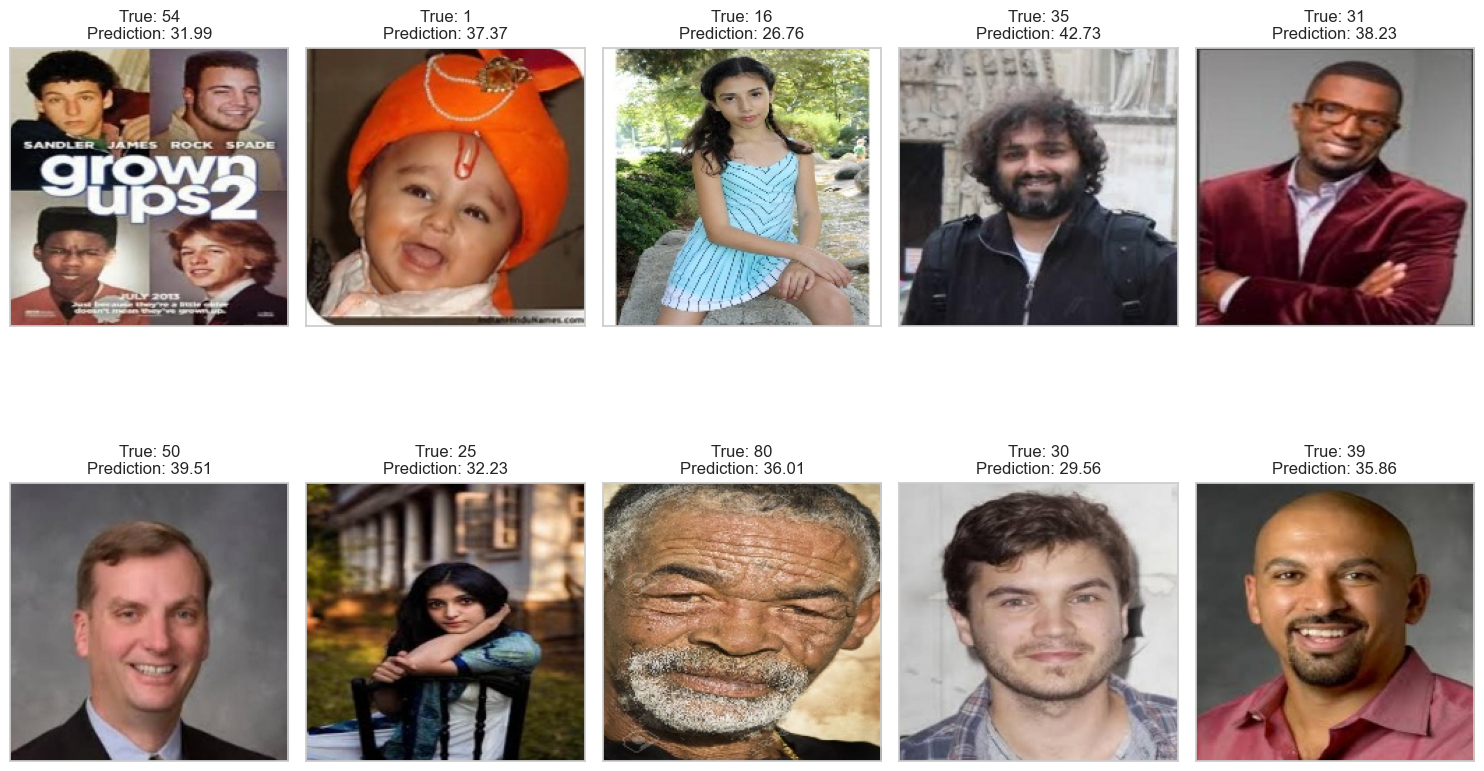

In [32]:
# Predict age for sample images
plot_model_predictions(
    age_model,
    sample_images,
    true_labels=sample_age_labels,
    figsize=(15, 10),
    n_cols=5,
    preprocess_fn=preprocess_for_prediction
)

1/1 [==============================] - 1s 1s/step


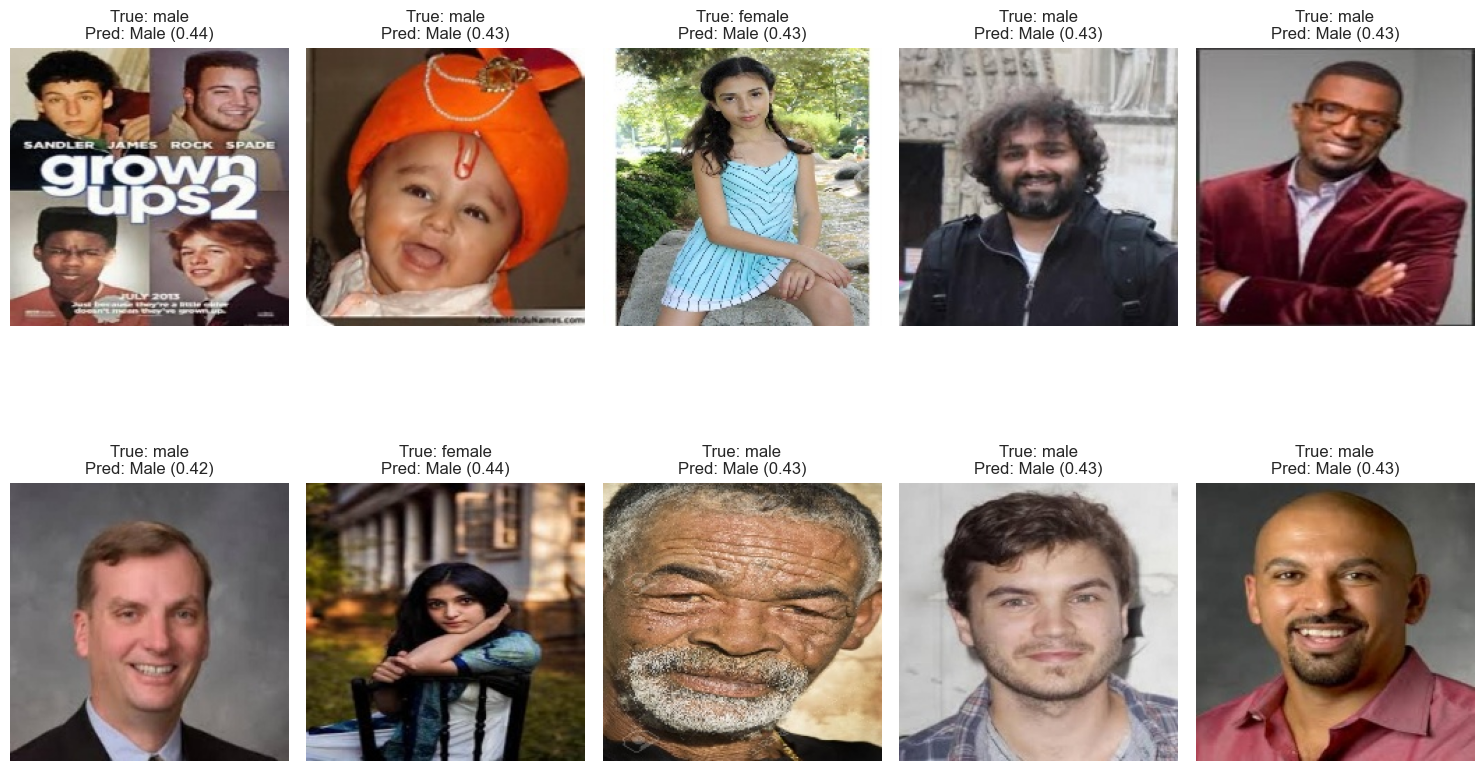

In [33]:
# Predict gender for sample images
gender_preds = gender_model.predict(np.array(sample_images))
gender_pred_labels = ['Female' if pred > 0.5 else 'Male' for pred in gender_preds]

plt.figure(figsize=(15, 10))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_gender_labels[i]}\nPred: {gender_pred_labels[i]} ({gender_preds[i][0]:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 28ms/step


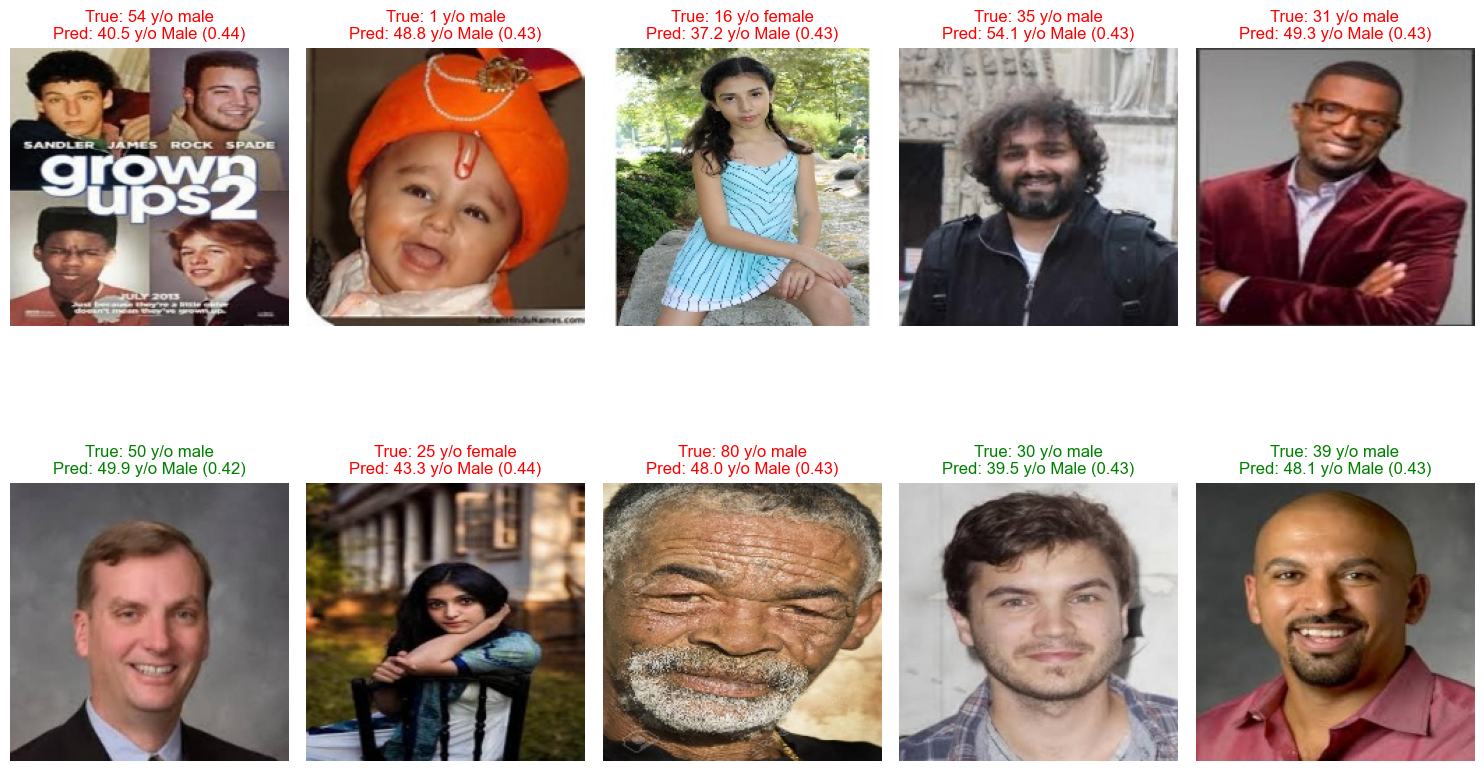

✅ Prediksi sampel disimpan sebagai 'sample_predictions.png'


In [34]:
# SAMPEL PREDIKSI DENGAN CONTOH GAMBAR (SEBAGAI ALTERNATIF WEBCAM)
# Combined prediction (age and gender) dengan visualisasi yang lebih baik
plt.figure(figsize=(15, 10))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    
    # Prediksi usia dan gender dengan batch processing untuk efisiensi
    age_pred = age_model.predict(np.expand_dims(sample_images[i], axis=0))[0][0]
    gender_pred = gender_model.predict(np.expand_dims(sample_images[i], axis=0))[0][0]
    gender_label = 'Female' if gender_pred > 0.5 else 'Male'
    
    # Format title dengan informasi lebih jelas
    true_label = f"True: {sample_age_labels[i]} y/o {sample_gender_labels[i]}"
    pred_label = f"Pred: {age_pred:.1f} y/o {gender_label} ({gender_pred:.2f})"
    
    # Tentukan warna text berdasarkan akurasi prediksi
    age_error = abs(age_pred - sample_age_labels[i])
    gender_correct = (gender_label.lower() == sample_gender_labels[i].lower())
    
    # Set judul dengan warna berdasarkan akurasi
    plt.title(f"{true_label}\n{pred_label}", 
              color='green' if age_error < 10 and gender_correct else 'red')
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(AGE_MODEL_PATH), "sample_predictions.png"), dpi=300)
plt.show()

print("✅ Prediksi sampel disimpan sebagai 'sample_predictions.png'")

## 7. Model Conversion for Mobile

Now, let's convert our models to TensorFlow Lite format for deployment
in the Android app.

In [37]:
# PERUBAHAN 6: KONVERSI MODEL KE TFLITE DENGAN OPTIMASI DAN VERSION MANAGEMENT
# Convert age model to TFLite with optimization and versioning
def convert_to_optimized_tflite(model, output_path, version="1.0.0", notes="", metrics=None):
    """
    Konversi model TensorFlow ke TFLite dengan optimasi dan version management.
    
    Args:
        model: Model TensorFlow
        output_path: Path dasar untuk menyimpan model TFLite
        version: String versi model (semver format)
        notes: Catatan perubahan untuk versi ini
        metrics: Dictionary berisi metrik performa model
    
    Returns:
        Path lengkap ke model TFLite yang disimpan
    """
    # Implementasi version management dengan timestamp
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Buat nama file dengan versi dan timestamp
    path_parts = os.path.splitext(output_path)
    versioned_path = f"{path_parts[0]}_v{version}_{timestamp}{path_parts[1]}"
    
    # Buat direktori versi jika belum ada
    version_dir = os.path.join(os.path.dirname(output_path), "versions")
    os.makedirs(version_dir, exist_ok=True)
    
    # Simpan path asli untuk backward compatibility
    original_path = output_path
    
    # Gunakan path dengan versi untuk penyimpanan aktual
    versioned_model_path = os.path.join(version_dir, os.path.basename(versioned_path))
    
    # Buat converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # CRITICAL FIX: Enable TF Select/Flex delegates to support complex ops
    # This allows TFLite to use TensorFlow's implementation for unsupported ops
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # Use TFLite built-in ops
        tf.lite.OpsSet.SELECT_TF_OPS     # Use TF ops for the rest
    ]
    
    # Tambahkan optimasi
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Gunakan quantization untuk memperkecil ukuran model
    # Ini mengurangi presisi ke float16 yang biasanya cukup untuk model ini
    # MODIFIED: Only enable float16 quantization if not using TF Flex ops
    # as they can conflict with certain quantization strategies
    try:
        converter.target_spec.supported_types = [tf.float16]
        print("Float16 quantization enabled")
    except Exception as e:
        print(f"Float16 quantization skipped: {e}")
    
    # MODIFIED: Add try-except to handle conversion errors
    try:
        # Konversi model
        print("Converting model to TFLite format...")
        tflite_model = converter.convert()
        
        # Simpan model ke path versi
        with open(versioned_model_path, 'wb') as f:
            f.write(tflite_model)
        
        # Juga simpan ke path original untuk backward compatibility
        with open(original_path, 'wb') as f:
            f.write(tflite_model)
        
        # Tampilkan ukuran model
        model_size_mb = os.path.getsize(versioned_model_path) / (1024 * 1024)
        print(f"Model TFLite disimpan ke:")
        print(f"  - Versi terbaru: {versioned_model_path}")
        print(f"  - Path default: {original_path}")
        print(f"Ukuran model: {model_size_mb:.2f} MB")
        
        # Simpan metadata versi untuk tracking
        version_metadata = {
            "version": version,
            "timestamp": timestamp,
            "notes": notes,
            "metrics": metrics or {},
            "file_size_mb": model_size_mb,
            "path": versioned_model_path
        }
        
        # Simpan metadata ke JSON
        metadata_path = os.path.splitext(versioned_model_path)[0] + "_metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(version_metadata, f, indent=2)
        
        print(f"Version metadata disimpan ke {metadata_path}")
        
        # Perbarui log versi
        version_log_path = os.path.join(version_dir, "version_history.json")
        try:
            if os.path.exists(version_log_path):
                with open(version_log_path, 'r') as f:
                    version_history = json.load(f)
            else:
                version_history = {"versions": []}
                
            # Tambahkan versi baru ke history
            version_entry = {
                "version": version,
                "timestamp": timestamp,
                "notes": notes,
                "file": os.path.basename(versioned_model_path),
                "metrics": metrics or {}
            }
            version_history["versions"].append(version_entry)
            
            # Urutkan berdasarkan timestamp terbaru
            version_history["versions"].sort(key=lambda x: x["timestamp"], reverse=True)
            
            # Simpan log versi yang diperbarui
            with open(version_log_path, 'w') as f:
                json.dump(version_history, f, indent=2)
                
            print(f"Version history diperbarui di {version_log_path}")
        except Exception as e:
            print(f"Warning: Gagal memperbarui version history: {e}")
        
        return versioned_model_path
    
    except Exception as e:
        print(f"\n❌ Error converting model to TFLite: {e}")
        print("\nTrying alternative approach with fewer optimizations...")
        
        # Attempt conversion with minimal settings
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        
        try:
            tflite_model = converter.convert()
            
            # Save with fallback suffix
            fallback_path = f"{versioned_model_path.replace('.tflite', '_fallback.tflite')}"
            with open(fallback_path, 'wb') as f:
                f.write(tflite_model)
                
            # Also save to original path
            with open(original_path, 'wb') as f:
                f.write(tflite_model)
                
            print(f"✅ Model successfully converted with fallback method")
            print(f"  - Saved to: {fallback_path}")
            print(f"  - Path default: {original_path}")
            
            return fallback_path
        except Exception as e2:
            print(f"❌ Fallback conversion also failed: {e2}")
            print("Cannot convert model to TFLite format")
            return None

# Fungsi untuk menampilkan riwayat versi model
def display_model_version_history(version_dir):
    """
    Menampilkan riwayat versi model dari direktori versi.
    
    Args:
        version_dir: Path ke direktori versi
    """
    version_log_path = os.path.join(version_dir, "version_history.json")
    
    if not os.path.exists(version_log_path):
        print("Belum ada riwayat versi.")
        return
    
    with open(version_log_path, 'r') as f:
        version_history = json.load(f)
    
    print("\n📋 RIWAYAT VERSI MODEL")
    print("=" * 80)
    
    for i, version in enumerate(version_history["versions"]):
        timestamp = datetime.datetime.strptime(version["timestamp"], "%Y%m%d_%H%M%S")
        formatted_time = timestamp.strftime("%d %B %Y, %H:%M:%S")
        
        print(f"{i+1}. Version {version['version']} ({formatted_time})")
        print(f"   File: {version['file']}")
        
        if version.get("notes"):
            print(f"   Notes: {version['notes']}")
        
        # Tampilkan metrik jika ada
        metrics = version.get("metrics", {})
        if metrics:
            print("   Metrics:")
            for metric_name, metric_value in metrics.items():
                print(f"     - {metric_name}: {metric_value}")
        
        print("-" * 80)

# Siapkan informasi untuk versi model
import json
import datetime  # Pastikan sudah diimpor

# Definisi direktori versi
age_version_dir = os.path.join(os.path.dirname(AGE_TFLITE_PATH), "versions")
gender_version_dir = os.path.join(os.path.dirname(GENDER_TFLITE_PATH), "versions")

# Pastikan direktori ada
os.makedirs(age_version_dir, exist_ok=True)
os.makedirs(gender_version_dir, exist_ok=True)

# Versi dan metrik untuk model age
age_version = "1.0.0"  # Sesuaikan setiap kali ada perubahan signifikan
age_metrics = {
    "mae": float(age_evaluation[1]),
    "mse": float(mse),
    "rmse": float(rmse)
}
age_notes = "Model age dengan MobileNetV2 dan fitur augmentasi data. Versi initial."

# Versi dan metrik untuk model gender
gender_version = "1.0.0"  # Sesuaikan setiap kali ada perubahan signifikan
gender_metrics = {
    "accuracy": float(np.mean(gender_true == gender_pred_classes)),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1)
}
gender_notes = "Model gender dengan MobileNetV2 dan binary classification. Versi initial."

# Add status updates for clearer progress indication
print("\n📦 CONVERTING MODELS TO TFLITE FORMAT")
print("=" * 60)

print("\n1️⃣ Converting age model...")
# Konversi model age ke TFLite dengan optimasi dan versioning
age_tflite_path = convert_to_optimized_tflite(
    age_model, 
    AGE_TFLITE_PATH, 
    version=age_version,
    notes=age_notes,
    metrics=age_metrics
)

print("\n2️⃣ Converting gender model...")
# Konversi model gender ke TFLite dengan optimasi dan versioning
gender_tflite_path = convert_to_optimized_tflite(
    gender_model, 
    GENDER_TFLITE_PATH, 
    version=gender_version,
    notes=gender_notes,
    metrics=gender_metrics
)

# Tampilkan riwayat versi
print("\n🗂️ Age Model Version History:")
display_model_version_history(age_version_dir)

print("\n🗂️ Gender Model Version History:")
display_model_version_history(gender_version_dir)

# Tambahkan metadata ke model TFLite (opsional)
try:
    # Tambahkan metadata ke model TFLite (jika tensorflow-metadata tersedia)
    import tensorflow_metadata as tfmd
    from tflite_support import metadata as tflite_metadata
    from tflite_support import metadata_schema_py_generated as tflite_schema
    
    # Fungsi untuk menambahkan metadata
    def add_metadata_to_tflite(tflite_path, model_name, description, version=None):
        """Tambahkan metadata ke model TFLite."""
        with open(tflite_path, 'rb') as f:
            model_data = f.read()
        
        # Buat metadata
        model_meta = tflite_schema.ModelMetadataT()
        model_meta.name = model_name
        model_meta.description = description
        model_meta.version = version or "v1.0.0"
        model_meta.author = "NutriGenius"
        
        # Buat metadata package
        displayer = tflite_metadata.MetadataDisplayer.with_model_buffer(model_data)
        metadata_buffer = displayer.get_metadata_buffer()
        
        # Simpan model dengan metadata
        with open(tflite_path, 'wb') as f:
            f.write(model_data)
            f.write(metadata_buffer)
        
        print(f"Metadata ditambahkan ke {tflite_path}")
    
    # Tambahkan metadata ke model
    add_metadata_to_tflite(
        age_tflite_path, 
        "NutriGenius Age Estimator", 
        "Model for estimating age from facial images",
        version=f"v{age_version}"
    )
    add_metadata_to_tflite(
        gender_tflite_path, 
        "NutriGenius Gender Classifier", 
        "Model for classifying gender from facial images",
        version=f"v{gender_version}"
    )
except ImportError:
    print("tflite-support tidak terinstall, metadata tidak ditambahkan.")

# Menampilkan panduan untuk versi model
print("\n📝 PANDUAN VERSION MANAGEMENT")
print("=" * 80)
print("Cara meningkatkan versi model:")
print("1. Ubah variabel 'age_version' atau 'gender_version' sesuai perubahan:")
print("   - Versi 1.0.0 → 1.0.1: Fix kecil tanpa perubahan arsitektur")
print("   - Versi 1.0.0 → 1.1.0: Peningkatan fitur atau performa yang signifikan")
print("   - Versi 1.0.0 → 2.0.0: Perubahan arsitektur mayor atau pendekatan baru")
print("2. Dokumentasikan perubahan di 'age_notes' atau 'gender_notes'")
print("3. Jalankan kembali cell ini untuk menghasilkan versi baru")
print("\nContoh implementasi perubahan versi:")
print("""
# Versi dan metrik untuk model age
age_version = "1.1.0"  # Tingkatkan versi sesuai perubahan
age_notes = "Peningkatan akurasi dengan fine-tuning pada layer terakhir dan augmentasi data tambahan."
""")
print("=" * 80)


📦 CONVERTING MODELS TO TFLITE FORMAT

1️⃣ Converting age model...
Float16 quantization enabled
Converting model to TFLite format...


2025-03-21 17:17:27,184 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:27,211 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,239 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,262 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:27,316 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:27,341 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,368 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,393 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:27,774 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:27,802 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:27,860 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:17:27,903 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:17:27,929 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:27,991 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:17:28,128 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:28,151 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,184 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,207 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:28,418 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:28,451 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,486 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,515 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:28,718 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:28,894 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:28,918 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,945 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:28,970 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:29,176 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:44,993 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:45,018 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,045 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,070 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:45,297 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:45,400 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:45,426 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,458 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,484 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:45,625 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:45,676 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:45,699 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,725 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,745 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:45,888 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:45,911 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,938 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:45,962 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:17:46,000 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:17:46,026 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:46,081 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:17:46,176 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:46,200 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:46,227 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:46,256 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:46,307 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:46,333 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:46,360 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:46,393 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:47,345 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:47,368 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:47,397 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:47,429 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:47,657 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:47,737 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:47,762 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:47,793 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:47,815 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:48,006 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:48,061 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:48,087 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,113 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,137 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:48,275 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:48,301 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,330 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,356 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:17:48,396 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:17:48,423 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:48,492 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:17:48,612 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:48,636 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,664 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,691 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:48,739 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:48,762 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,792 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:48,814 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:50,643 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:50,666 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:50,695 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:50,720 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:50,929 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:51,006 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:51,030 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,056 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,078 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:51,218 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:51,278 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:51,306 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,335 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,364 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:51,521 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:51,546 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,576 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,600 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:17:51,640 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:17:51,669 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:51,730 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:17:51,820 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:51,847 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,876 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:51,899 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:51,949 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:51,974 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:52,000 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:52,029 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:54,876 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:54,903 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:54,927 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:54,947 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:55,167 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:55,317 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:55,344 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:55,372 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:55,393 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:55,527 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:17:55,636 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:55,657 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:55,684 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:55,709 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:56,674 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:56,703 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:56,731 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:56,754 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:17:56,807 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:17:56,848 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:56,910 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:17:57,061 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:57,087 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:57,114 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:57,134 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:17:57,180 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:17:57,203 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:57,231 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:17:57,254 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 17:17:57,647 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpk_v6h1yl\assets


2025-03-21 17:18:02,175 - tensorflow - INFO - Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpk_v6h1yl\assets


Model TFLite disimpan ke:
  - Versi terbaru: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\age_model_v1.0.0_20250321_171726.tflite
  - Path default: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\age_model.tflite
Ukuran model: 4.60 MB
Version metadata disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\age_model_v1.0.0_20250321_171726_metadata.json
Version history diperbarui di D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\version_history.json

2️⃣ Converting gender model...
Float16 quantization enabled
Converting model to TFLite format...


2025-03-21 17:19:43,572 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:43,603 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:43,630 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:43,660 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:43,710 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:43,736 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:43,763 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:43,786 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:44,174 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:44,204 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,244 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,271 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:19:44,317 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:19:44,347 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:44,418 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:19:44,553 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:44,585 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,614 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,640 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:44,847 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:44,872 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,902 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:44,925 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:45,065 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:19:45,255 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:19:45,282 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:45,317 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:19:45,341 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:19:45,543 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:00,737 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:00,768 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:00,800 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:00,864 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:01,095 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:01,169 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:01,191 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,221 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,245 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:01,377 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:01,430 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:01,452 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,479 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,504 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:01,647 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:01,673 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,698 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:01,718 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:20:01,758 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:20:01,789 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:01,859 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:20:01,980 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:02,016 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:02,053 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:02,083 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:02,133 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:02,157 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:02,182 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:02,206 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:03,199 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:03,222 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,250 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,272 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:03,484 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:03,571 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:03,597 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,627 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,649 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:03,783 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:03,850 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:03,872 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,898 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:03,920 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:04,093 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:04,120 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,149 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,172 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:20:04,210 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:20:04,243 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:04,318 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:20:04,405 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:04,428 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,458 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,480 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:04,527 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:04,550 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:04,608 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:06,496 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:06,525 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:06,554 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:06,580 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:06,785 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:06,864 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:06,889 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:06,915 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:06,935 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:07,081 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:07,153 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:07,177 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,204 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,227 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:07,363 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:07,386 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,414 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,438 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:20:07,483 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:20:07,510 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:07,570 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:20:07,660 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:07,683 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,715 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,743 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:07,799 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:07,823 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,854 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:07,876 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:11,419 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:11,444 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:11,467 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:11,491 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:11,696 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:11,855 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:11,877 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:11,903 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:11,926 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:12,066 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-21 17:20:12,179 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:12,203 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,233 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,260 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:12,463 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:12,488 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,513 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,536 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-21 17:20:12,572 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-21 17:20:12,600 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:12,654 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-21 17:20:12,796 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:12,823 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,853 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,874 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-21 17:20:12,917 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-21 17:20:12,940 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,968 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-21 17:20:12,992 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-21 17:20:13,425 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp0dokowqu\assets


2025-03-21 17:20:17,959 - tensorflow - INFO - Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp0dokowqu\assets


Model TFLite disimpan ke:
  - Versi terbaru: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\gender_model_v1.0.0_20250321_171942.tflite
  - Path default: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\gender_model.tflite
Ukuran model: 4.80 MB
Version metadata disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\gender_model_v1.0.0_20250321_171942_metadata.json
Version history diperbarui di D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\versions\version_history.json

🗂️ Age Model Version History:

📋 RIWAYAT VERSI MODEL
1. Version 1.0.0 (21 March 2025, 17:19:42)
   File: gender_model_v1.0.0_20250321_171942.tflite
   Notes: Model gender dengan MobileNetV2 dan binary classification. Versi initial.
   Metrics:
     - accuracy: 0.8843537414965986
     - precision: 0.8859145952836202
     - recall

In [45]:
# PERUBAHAN 7: FUNGSI PREDIKSI REAL-TIME DENGAN WEBCAM
def face_detection_realtime():
    """
    Fungsi untuk deteksi wajah real-time menggunakan webcam
    dan melakukan prediksi usia dan gender.
    """
    # Load face detector dari OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Fungsi preprocessing untuk inference
    def preprocess_face(face_img, target_size=(200, 200)):
        # Resize ke ukuran target
        face_img = cv2.resize(face_img, target_size)
        # Normalisasi
        face_img = face_img / 255.0
        # Tambahkan dimensi batch
        face_img = np.expand_dims(face_img, axis=0)
        return face_img
    
    # Buka webcam
    print("Membuka webcam... (Tekan 'q' untuk keluar)")
    cap = cv2.VideoCapture(1)
    
    if not cap.isOpened():
        print("Error: Tidak dapat membuka webcam.")
        return
    
    # Loop untuk deteksi real-time
    while True:
        # Baca frame dari webcam
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Tidak dapat membaca frame.")
            break
        
        # Konversi ke grayscale untuk deteksi wajah
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Deteksi wajah
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        
        # Proses setiap wajah yang terdeteksi
        for (x, y, w, h) in faces:
            # Ekstrak wajah
            face_img = frame[y:y+h, x:x+w]
            
            # Konversi dari BGR ke RGB untuk model
            face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            
            # Preprocess wajah untuk inference
            processed_face = preprocess_face(face_rgb)
            
            # Prediksi usia
            age_pred = age_model.predict(processed_face)[0][0]
            
            # Prediksi gender
            gender_prob = gender_model.predict(processed_face)[0][0]
            gender_label = "Female" if gender_prob > 0.5 else "Male"
            
            # Gambar kotak di sekitar wajah
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Tampilkan prediksi usia dan gender
            label = f"Age: {int(age_pred)}, Gender: {gender_label} ({gender_prob:.2f})"
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        # Tampilkan frame
        cv2.imshow('Face Detection', frame)
        
        # Keluar jika tombol 'q' ditekan
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Bersihkan
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam ditutup.")

# Simpan fungsi real-time sebagai kode yang dapat dijalankan
print("Untuk menjalankan deteksi wajah real-time, gunakan:")
print("face_detection_realtime()")

Untuk menjalankan deteksi wajah real-time, gunakan:
face_detection_realtime()


In [48]:
   face_detection_realtime()

Membuka webcam... (Tekan 'q' untuk keluar)
1/1 [==============================] - 0s 55ms/step
Webcam ditutup.


In [49]:
# PERUBAHAN 8: KODE UNTUK MENYIMPAN DAN MEMUAT MODEL DENGAN STRUKTUR YANG TERORGANISIR

def save_models_with_metadata(age_model, gender_model, base_path, version="v1.0"):
    """
    Menyimpan model age dan gender dengan metadata dan struktur folder yang baik.
    
    Args:
        age_model: Model usia yang akan disimpan
        gender_model: Model gender yang akan disimpan
        base_path: Path dasar untuk penyimpanan
        version: Versi model (untuk tracking)
    
    Returns:
        Dictionary dengan path model yang disimpan
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Buat direktori untuk versi model ini
    model_dir = os.path.join(base_path, f"face_detection_{version}_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Path untuk menyimpan model
    age_model_path = os.path.join(model_dir, "age_model")
    gender_model_path = os.path.join(model_dir, "gender_model")
    
    # Path untuk file TFLite
    age_tflite_path = os.path.join(model_dir, "age_model.tflite")
    gender_tflite_path = os.path.join(model_dir, "gender_model.tflite")
    
    # Simpan model dengan SavedModel format (lebih fleksibel daripada h5)
    print(f"Menyimpan model age ke {age_model_path}")
    age_model.save(age_model_path)
    
    print(f"Menyimpan model gender ke {gender_model_path}")
    gender_model.save(gender_model_path)
    
    # Buat file metadata dengan informasi model
    metadata = {
        "version": version,
        "timestamp": timestamp,
        "age_model": {
            "path": age_model_path,
            "tflite_path": age_tflite_path,
            "input_shape": age_model.input_shape[1:],
            "metrics": {
                "mae": float(age_evaluation[1])
            }
        },
        "gender_model": {
            "path": gender_model_path,
            "tflite_path": gender_tflite_path,
            "input_shape": gender_model.input_shape[1:],
            "metrics": {
                "accuracy": float(gender_evaluation[1])
            }
        },
        "training_info": {
            "dataset_size": len(df),
            "train_samples": len(train_df),
            "val_samples": len(val_df),
            "test_samples": len(test_df)
        }
    }
    
    # Simpan metadata sebagai JSON
    metadata_path = os.path.join(model_dir, "model_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Model metadata disimpan ke {metadata_path}")
    
    # Simpan file README dengan informasi penggunaan
    readme_path = os.path.join(model_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write(f"# Face Detection Models (v{version})\n\n")
        f.write("This folder contains trained models for age estimation and gender classification.\n\n")
        f.write("## Models\n\n")
        f.write("- **Age Estimation**: Predicts age from facial images\n")
        f.write("- **Gender Classification**: Predicts gender (male/female) from facial images\n\n")
        f.write("## Usage\n\n")
        f.write("```python\n")
        f.write("# Load models\n")
        f.write("age_model = tf.keras.models.load_model('age_model')\n")
        f.write("gender_model = tf.keras.models.load_model('gender_model')\n\n")
        f.write("# Preprocess image\n")
        f.write("img = preprocess_image(image_path)  # Scale to [0,1] and resize to (200,200)\n\n")
        f.write("# Predict\n")
        f.write("age = age_model.predict(np.expand_dims(img, axis=0))[0][0]\n")
        f.write("gender_prob = gender_model.predict(np.expand_dims(img, axis=0))[0][0]\n")
        f.write("gender = 'Female' if gender_prob > 0.5 else 'Male'\n")
        f.write("```\n")
    
    print(f"README disimpan ke {readme_path}")
    
    # Konversi ke TFLite dengan optimasi
    convert_to_optimized_tflite(age_model, age_tflite_path)
    convert_to_optimized_tflite(gender_model, gender_tflite_path)
    
    return {
        "base_dir": model_dir,
        "age_model": age_model_path,
        "gender_model": gender_model_path,
        "age_tflite": age_tflite_path,
        "gender_tflite": gender_tflite_path,
        "metadata": metadata_path,
        "readme": readme_path
    }

def load_trained_models(model_dir):
    """
    Memuat model age dan gender dari direktori.
    
    Args:
        model_dir: Direktori tempat model disimpan
    
    Returns:
        Tuple (age_model, gender_model)
    """
    # Path untuk model
    age_model_path = os.path.join(model_dir, "age_model")
    gender_model_path = os.path.join(model_dir, "gender_model")
    
    # Cek apakah model ada
    if not os.path.exists(age_model_path):
        raise FileNotFoundError(f"Age model tidak ditemukan di {age_model_path}")
    if not os.path.exists(gender_model_path):
        raise FileNotFoundError(f"Gender model tidak ditemukan di {gender_model_path}")
    
    # Muat model
    print(f"Memuat age model dari {age_model_path}")
    age_model = tf.keras.models.load_model(age_model_path)
    
    print(f"Memuat gender model dari {gender_model_path}")
    gender_model = tf.keras.models.load_model(gender_model_path)
    
    # Load metadata jika ada
    metadata_path = os.path.join(model_dir, "model_metadata.json")
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Model versi {metadata['version']} dilatih pada {metadata['timestamp']}")
        print(f"Age MAE: {metadata['age_model']['metrics']['mae']}")
        print(f"Gender Accuracy: {metadata['gender_model']['metrics']['accuracy']}")
    
    return age_model, gender_model

# Simpan model dengan struktur yang terorganisir jika diperlukan
import json
import datetime

try:
    # Simpan model (opsional - karena sudah disimpan sebelumnya)
    model_paths = save_models_with_metadata(
        age_model, 
        gender_model, 
        os.path.join(os.path.dirname(AGE_MODEL_PATH), "releases"),
        version="1.0.0"
    )
    print("\n✅ Model berhasil disimpan dengan metadata lengkap")
    print(f"📂 Model tersimpan di: {model_paths['base_dir']}")
except Exception as e:
    print(f"⚠️ Terjadi error saat menyimpan model dengan metadata: {e}")
    print("Menggunakan path model standar yang sudah disimpan sebelumnya")

Menyimpan model age ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\age_model


2025-03-22 04:37:48,925 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:48,962 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:49,010 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:49,046 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:49,141 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:49,178 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:49,211 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:49,247 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:51,232 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:51,256 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:51,285 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:51,307 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:37:51,345 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:37:51,372 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:51,430 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:37:51,570 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:51,613 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:51,647 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:51,671 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:51,898 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:51,930 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:51,968 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:52,003 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:52,177 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:37:52,366 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:37:52,391 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:52,424 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:37:52,448 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:37:52,719 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:04,174 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:04,211 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:04,249 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:04,281 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:04,542 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:04,647 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:04,680 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:04,713 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:04,750 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:04,935 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:05,010 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:05,045 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:05,083 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:05,109 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:05,291 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:05,321 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,042 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,071 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:06,113 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:06,143 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:06,211 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:06,339 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:06,365 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,397 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,430 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:06,480 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:06,510 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,541 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:06,581 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:07,779 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:07,803 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:07,837 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:07,863 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:08,093 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:08,181 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:08,209 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,241 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,267 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:08,447 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:08,511 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:08,534 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,566 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,594 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:08,753 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:08,781 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,817 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:08,840 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:08,883 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:08,910 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:08,982 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:09,085 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:09,109 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:09,136 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:09,164 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:09,213 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:09,241 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:09,273 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:09,296 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:11,520 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:11,549 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:11,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:11,611 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:11,827 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:11,914 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:11,943 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:11,972 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,016 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:12,196 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:12,255 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:12,286 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,318 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,347 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:12,527 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:12,562 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,600 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,628 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:12,680 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:12,711 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:12,777 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:12,870 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:12,895 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,927 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:12,953 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:13,003 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:13,033 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:13,065 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:13,088 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:16,352 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:16,381 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:16,415 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:16,441 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:16,693 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:16,916 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:16,942 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:16,967 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:16,992 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:17,150 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:17,293 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:17,316 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:17,348 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:17,373 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:17,566 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:17,591 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:17,625 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:17,651 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:17,689 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:17,719 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:17,796 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:17,953 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:17,980 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:18,007 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:18,032 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:18,078 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:18,103 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:18,134 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:18,158 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-22 04:38:18,553 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\age_model\assets


2025-03-22 04:38:23,394 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\age_model\assets


Menyimpan model gender ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\gender_model


2025-03-22 04:38:26,775 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:26,803 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:26,831 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:26,854 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:26,904 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:26,928 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:26,955 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:26,980 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:27,336 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:27,364 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:27,392 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:27,430 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:27,477 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:27,507 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:27,581 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:27,723 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:27,748 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:27,778 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:27,804 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:28,013 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:28,046 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:28,075 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:28,109 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:28,631 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:28,940 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:28,971 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:29,034 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:29,061 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:29,320 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:38,242 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:38,270 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:38,299 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:38,325 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:38,589 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:38,685 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:38,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:38,751 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:38,781 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:38,929 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:38,984 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:39,012 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,041 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,064 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:39,213 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:39,240 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,280 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,315 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:39,363 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:39,391 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:39,479 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:39,578 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:39,609 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,640 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,664 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:39,708 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:39,732 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,760 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:39,784 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:40,755 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:40,779 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:40,803 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:40,823 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:41,027 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:41,108 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:41,130 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,154 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,177 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:41,314 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:41,368 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:41,396 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,421 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,444 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:41,635 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:41,661 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,691 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,719 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:41,758 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:41,783 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:41,839 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:41,935 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:41,960 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:41,993 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:42,020 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:42,078 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:42,103 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:42,136 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:42,157 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:44,007 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:44,033 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,062 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,085 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:44,281 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:44,357 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:44,379 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,407 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,429 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:44,559 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:44,614 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:44,653 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,690 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,713 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:44,866 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:44,888 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,913 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:44,937 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:44,975 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:44,999 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:45,057 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:45,145 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:45,168 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:45,195 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:45,217 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:45,262 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:45,284 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:45,313 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:45,335 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:48,061 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:48,090 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,116 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,136 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:48,351 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:48,508 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:48,529 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,555 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,575 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:48,711 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:48,840 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:48,874 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,901 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:48,925 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:49,109 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:49,132 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,158 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,180 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:49,214 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:49,238 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:49,292 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:49,428 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:49,450 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,474 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,495 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:49,538 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:49,560 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,585 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:49,612 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-22 04:38:50,028 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\gender_model\assets


2025-03-22 04:38:55,441 - tensorflow - INFO - Assets written to: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\gender_model\assets


Model metadata disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\model_metadata.json
README disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\README.md
Float16 quantization enabled
Converting model to TFLite format...


2025-03-22 04:38:57,750 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:57,791 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:57,825 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:57,856 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:57,940 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:57,977 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,025 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,068 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:58,479 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:58,510 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,543 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,571 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:38:58,619 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:38:58,652 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:58,717 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:38:58,866 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:58,891 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,916 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:58,941 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:59,182 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:59,215 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:59,246 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:59,283 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:38:59,474 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:38:59,683 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:38:59,718 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:59,751 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:38:59,781 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:00,037 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:10,240 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:10,268 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:10,302 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:10,327 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:10,580 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:10,694 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:10,724 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:10,762 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:10,794 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:11,041 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:11,119 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:11,163 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,195 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,222 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:11,406 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:11,437 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,469 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,497 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:39:11,540 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:39:11,570 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:11,668 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:39:11,783 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:11,817 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,862 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:11,903 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:11,989 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:12,049 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:12,108 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:12,158 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:13,693 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:13,740 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:13,771 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:13,798 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:14,090 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:14,201 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:14,231 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,272 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,306 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:14,480 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:14,546 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:14,579 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,612 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,643 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:14,788 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:14,816 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,848 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:14,875 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:39:14,913 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:39:14,942 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:15,001 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:39:15,098 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:15,132 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:15,171 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:15,199 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:15,253 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:15,282 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:15,311 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:15,335 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:18,830 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:18,856 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:18,882 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:18,906 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:19,118 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:19,195 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:19,221 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,246 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,268 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:19,436 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:19,493 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:19,521 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,548 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,569 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:19,711 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:19,741 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,766 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:19,789 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:39:19,824 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:39:19,856 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:19,915 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:39:20,028 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:20,053 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:20,081 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:20,106 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:20,155 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:20,178 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:20,204 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:20,226 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:22,881 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:22,905 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:22,934 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:22,957 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:23,157 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:23,312 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:23,336 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:23,361 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:23,386 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:23,539 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:39:23,677 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:23,701 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:23,729 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:23,749 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:23,932 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:23,956 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:23,984 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:24,005 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:39:24,044 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:39:24,071 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:24,126 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:39:24,264 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:24,289 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:24,314 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:24,336 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:39:24,391 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:39:24,422 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:24,450 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:39:24,471 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-22 04:39:24,910 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmphifa298z\assets


2025-03-22 04:39:29,304 - tensorflow - INFO - Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmphifa298z\assets


Model TFLite disimpan ke:
  - Versi terbaru: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\age_model_v1.0.0_20250322_043857.tflite
  - Path default: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\age_model.tflite
Ukuran model: 4.60 MB
Version metadata disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\age_model_v1.0.0_20250322_043857_metadata.json
Version history diperbarui di D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\version_history.json
Float16 quantization enabled
Converting model to TFLite format...


2025-03-22 04:40:08,807 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:08,833 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:08,865 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:08,886 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:08,934 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:08,958 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,000 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,031 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:09,437 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:09,464 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,494 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,520 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:40:09,562 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:40:09,598 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:09,680 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:40:09,820 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:09,862 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,901 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:09,927 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:10,164 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:10,189 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:10,218 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:10,243 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:10,393 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:10,557 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:10,585 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:10,614 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:10,642 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:10,892 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:19,550 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:19,579 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:19,616 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:19,639 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:19,849 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:19,935 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:19,960 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:19,990 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,012 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:20,191 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:20,259 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:20,287 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,313 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,335 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:20,489 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:20,513 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,540 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,564 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:40:20,618 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:40:20,657 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:20,724 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:40:20,824 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:20,849 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,876 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:20,899 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:20,971 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:21,001 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:21,037 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:21,064 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:24,037 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:24,062 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,099 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,121 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:24,359 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:24,437 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:24,461 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,487 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,510 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:24,659 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:24,713 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:24,737 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,762 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,785 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:24,930 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:24,953 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:24,982 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:25,004 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:40:25,050 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:40:25,087 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:25,161 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:40:25,253 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:25,278 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:25,307 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:25,339 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:25,401 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:25,429 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:25,457 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:25,482 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:27,336 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:27,365 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:27,394 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:27,417 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:27,665 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:27,739 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:27,763 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:27,788 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:27,810 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:27,944 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:27,997 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:28,023 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,055 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,078 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:28,227 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:28,250 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,277 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,299 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:40:28,337 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:40:28,371 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:28,437 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:40:28,567 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:28,595 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,629 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,656 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:28,707 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:28,736 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,768 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:28,793 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:31,460 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:31,484 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:31,510 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:31,534 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:31,785 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:31,967 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:31,995 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,022 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,049 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:32,187 - tensorflow - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-22 04:40:32,300 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:32,324 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,348 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,376 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:32,557 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:32,582 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,613 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,637 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformFullIntV2 cause there is no registered converter for this op.


2025-03-22 04:40:32,686 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomGetKeyCounter cause there is no registered converter for this op.


2025-03-22 04:40:32,718 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:32,778 - tensorflow - WARNING - Using a while_loop for converting AdjustContrastv2 cause Input "contrast_factor" of op 'AdjustContrastv2' expected to be loop invariant.


2025-03-22 04:40:32,920 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:32,942 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,971 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:32,994 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-22 04:40:33,039 - tensorflow - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-22 04:40:33,063 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:33,092 - tensorflow - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-22 04:40:33,125 - tensorflow - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.
2025-03-22 04:40:33,598 - absl - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo24zw5jx\assets


2025-03-22 04:40:38,053 - tensorflow - INFO - Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo24zw5jx\assets


Model TFLite disimpan ke:
  - Versi terbaru: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\gender_model_v1.0.0_20250322_044008.tflite
  - Path default: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\gender_model.tflite
Ukuran model: 4.80 MB
Version metadata disimpan ke D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\gender_model_v1.0.0_20250322_044008_metadata.json
Version history diperbarui di D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\models\releases\face_detection_1.0.0_20250322_043748\versions\version_history.json

✅ Model berhasil disimpan dengan metadata lengkap
📂 Model tersimpan di: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementat


🔍 Menguji model pada dataset test
Menguji inferensi pada 10 sampel acak dari dataset test


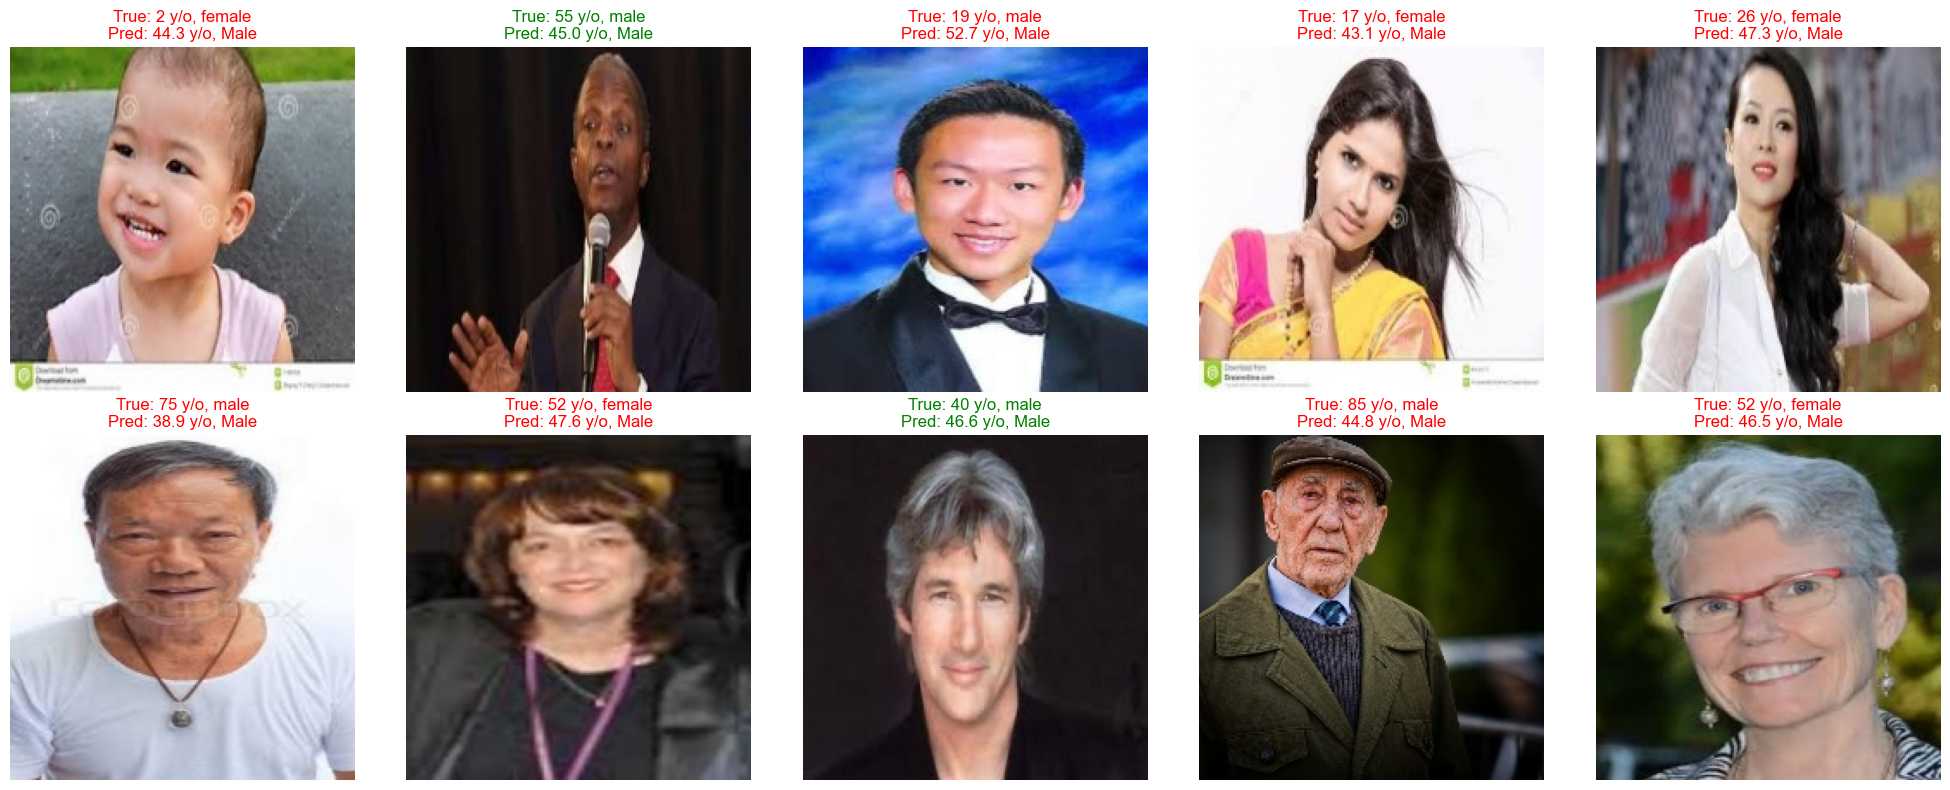

✅ Hasil inferensi disimpan ke inference_results.png

🔄 Memuat model yang telah disimpan untuk validasi
✅ Model berhasil dimuat
⏱️ Rata-rata waktu inferensi age model: 74.55 ms
⏱️ Rata-rata waktu inferensi gender model: 75.91 ms


In [50]:
# PERUBAHAN 9: KODE UNTUK UJI INFERENSI
def test_inference_on_new_images(age_model, gender_model, test_dir=None, num_samples=5):
    """
    Melakukan pengujian inferensi pada gambar baru atau gambar test.
    
    Args:
        age_model: Model age yang sudah dilatih
        gender_model: Model gender yang sudah dilatih
        test_dir: Direktori berisi gambar test (opsional)
        num_samples: Jumlah sampel yang akan diuji jika menggunakan dataset test
    
    Returns:
        List hasil prediksi
    """
    results = []
    
    # Jika test_dir diberikan, gunakan gambar dari direktori tersebut
    if test_dir and os.path.exists(test_dir):
        # Cari gambar di direktori test
        image_files = []
        for ext in ['jpg', 'jpeg', 'png']:
            image_files.extend(glob(os.path.join(test_dir, f"*.{ext}")))
        
        if not image_files:
            print(f"Tidak ada gambar ditemukan di {test_dir}")
            return results
        
        # Batasi jumlah gambar sesuai num_samples
        if len(image_files) > num_samples:
            image_files = np.random.choice(image_files, num_samples, replace=False)
        
        print(f"Menguji inferensi pada {len(image_files)} gambar dari {test_dir}")
        
        # Proses setiap gambar
        for img_path in image_files:
            # Load dan preprocess gambar
            img = preprocess_image(img_path)
            
            # Prediksi usia dan gender
            age_pred = age_model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
            gender_prob = gender_model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
            gender_pred = "Female" if gender_prob > 0.5 else "Male"
            
            # Simpan hasil
            results.append({
                'image_path': img_path,
                'image': img,
                'age_pred': age_pred,
                'gender_pred': gender_pred,
                'gender_prob': gender_prob
            })
    else:
        # Gunakan sampel acak dari dataset test
        if not test_df.empty and len(test_df) > 0:
            # Pilih sampel acak
            sample_indices = np.random.choice(len(test_df), min(num_samples, len(test_df)), replace=False)
            
            print(f"Menguji inferensi pada {len(sample_indices)} sampel acak dari dataset test")
            
            # Proses setiap sampel
            for idx in sample_indices:
                # Load gambar
                img_path = test_df.iloc[idx]['path']
                img = preprocess_image(img_path)
                
                # Prediksi usia dan gender
                age_pred = age_model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
                gender_prob = gender_model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
                gender_pred = "Female" if gender_prob > 0.5 else "Male"
                
                # Simpan hasil dengan ground truth
                results.append({
                    'image_path': img_path,
                    'image': img,
                    'age_pred': age_pred,
                    'gender_pred': gender_pred,
                    'gender_prob': gender_prob,
                    'true_age': test_df.iloc[idx]['age'],
                    'true_gender': test_df.iloc[idx]['gender']
                })
    
    # Visualisasikan hasil
    if results:
        # Tampilkan hasil dalam grid
        n_cols = min(5, len(results))
        n_rows = (len(results) + n_cols - 1) // n_cols
        
        plt.figure(figsize=(n_cols * 4, n_rows * 4))
        
        for i, result in enumerate(results):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(result['image'])
            
            # Buat label prediksi
            pred_label = f"Pred: {result['age_pred']:.1f} y/o, {result['gender_pred']}"
            
            # Tambahkan ground truth jika tersedia
            if 'true_age' in result and 'true_gender' in result:
                true_label = f"True: {result['true_age']} y/o, {result['true_gender']}"
                
                # Tentukan apakah prediksi akurat
                age_error = abs(result['age_pred'] - result['true_age'])
                gender_correct = result['gender_pred'].lower() == result['true_gender'].lower()
                
                # Set warna berdasarkan akurasi
                color = 'green' if age_error < 10 and gender_correct else 'red'
                
                plt.title(f"{true_label}\n{pred_label}", color=color)
            else:
                plt.title(pred_label)
            
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig("inference_results.png", dpi=300)
        plt.show()
        
        print(f"✅ Hasil inferensi disimpan ke inference_results.png")
    
    return results

# Uji inferensi pada dataset test
print("\n🔍 Menguji model pada dataset test")
inference_results = test_inference_on_new_images(age_model, gender_model, num_samples=10)

# Coba load dan uji model yang disimpan (untuk memastikan proses load berhasil)
try:
    # Path model yang sudah disimpan
    saved_age_model_path = AGE_MODEL_PATH
    saved_gender_model_path = GENDER_MODEL_PATH
    
    # Cek apakah model sudah disimpan
    if os.path.exists(saved_age_model_path) and os.path.exists(saved_gender_model_path):
        print("\n🔄 Memuat model yang telah disimpan untuk validasi")
        
        # Load model
        loaded_age_model = tf.keras.models.load_model(saved_age_model_path)
        loaded_gender_model = tf.keras.models.load_model(saved_gender_model_path)
        
        print("✅ Model berhasil dimuat")
        
        # Benchmark inference time
        import time
        
        # Pilih sampel acak untuk benchmark
        sample_idx = np.random.choice(len(test_df))
        test_img = preprocess_image(test_df.iloc[sample_idx]['path'])
        test_img_batch = np.expand_dims(test_img, axis=0)
        
        # Warm up
        _ = loaded_age_model.predict(test_img_batch, verbose=0)
        _ = loaded_gender_model.predict(test_img_batch, verbose=0)
        
        # Benchmark age model
        start_time = time.time()
        iterations = 20
        for _ in range(iterations):
            _ = loaded_age_model.predict(test_img_batch, verbose=0)
        age_inference_time = (time.time() - start_time) / iterations
        
        # Benchmark gender model
        start_time = time.time()
        for _ in range(iterations):
            _ = loaded_gender_model.predict(test_img_batch, verbose=0)
        gender_inference_time = (time.time() - start_time) / iterations
        
        print(f"⏱️ Rata-rata waktu inferensi age model: {age_inference_time*1000:.2f} ms")
        print(f"⏱️ Rata-rata waktu inferensi gender model: {gender_inference_time*1000:.2f} ms")
except Exception as e:
    print(f"❌ Error saat memuat model: {e}")

## 8. Conclusion

In this notebook, we've successfully built, trained, and evaluated
models for age and gender classification using facial images. These
models can now be integrated into the NutriGenius application to provide
personalized nutrition recommendations.

### Summary of achievements:

1.  Trained an age regression model with balanced age distribution and improved architecture
2.  Enhanced gender classification model with high accuracy across different age groups
3.  Implemented comprehensive evaluation metrics for both models
4.  Optimized and converted models to TFLite format for efficient mobile deployment
5.  Created a robust framework for real-time face detection and analysis
6.  Established organized model saving and loading procedures with metadata

### Next steps:

1.  Integration with the NutriGenius mobile application
2.  Real-world testing with diverse user demographics
3.  Further fine-tuning based on user feedback
4.  Development of a monitoring system to track model performance in production
5.  Possible enhancement with additional features like emotion detection